# Q1. Transformers Network

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
def seconds_to_hms(seconds):
    # Convert seconds to hours, minutes, and seconds
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    # Return formatted string
    return "%d hr:%02d min:%02d sec" % (h, m, s)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from torch.optim import AdamW

import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.nn.parallel import DataParallel


import matplotlib.pyplot as plt
import time
import os
import numpy as np
from tqdm import tqdm

## (a) Implementation of ViT (Vision Transformer) architecture.

In [4]:

# Hyperparameters
image_size = 64
patch_size = 4
num_classes = 10
in_channels = 3
dim = 64  # hidden_dim
depth = 4
heads = 8
mlp_ratio = 4 # (embed dim * 4) = mlp_dim, if dim = 768, then mlp_dim = 3072
batch_size = 128
num_epochs = 200
learning_rate = 1e-3



In [6]:
# ViT architecture
# non-overlapping patches

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=in_channels, patch_size=patch_size, embed_dim=dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == W, "Input tensor must be square"
        num_patches = (H // self.patch_size) ** 2
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        return x



class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(0.1)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(0.1)

    def forward(self, x):
        B, N, E = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.head_dim ** -0.5
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = attn @ v
        x = x.transpose(1, 2).reshape(B, N, E)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio):
        super(TransformerEncoder, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        hidden_features = int(embed_dim * mlp_ratio)
        self.mlp = MLP(embed_dim, hidden_features, embed_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_size=image_size,
        in_channels=in_channels,  
        patch_size=patch_size,
        embed_dim=dim,
        depth=depth,
        num_heads=heads,
        mlp_ratio=mlp_ratio,
        num_classes=num_classes,
    ):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, embed_dim)
        num_patches = (image_size // patch_size) * (image_size // patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(0.1)

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(TransformerEncoder(embed_dim, num_heads, mlp_ratio))

        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        B, N, E = x.shape
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed[:, :N+1, :]
        x = self.pos_drop(x)


     # model does not use the CLS tokens from different layers of the model, 
    # but only from the output of the final layer for classification
        for layer in self.layers:
            x = layer(x)
    #Here, x[:, 0] selects the CLS token from the output sequence of the final transformer layer. This CLS token is then passed through a Layer Normalization (self.norm) 
    #and a linear transformation (self.fc) to get the logits for the classes.
        x = self.norm(x[:, 0])
        x = self.fc(x)
        return x
    


## (b) Training the ViT model on CIFAR-10 dataset.

### (i) With patch_size = 4x4 (using a constant number of heads : heads = 8)

In [7]:

# Hyperparameters
image_size = 64
patch_size = 4
num_classes = 10
in_channels = 3
dim = 64  # hidden_dim
depth = 4
heads = 8
mlp_ratio = 4 # (embed dim * 4) = mlp_dim, if dim = 768, then mlp_dim = 3072
batch_size = 128
num_epochs = 200
learning_rate = 1e-3



In [8]:


transform_train = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


In [9]:
#Download dataset
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)



Files already downloaded and verified
Files already downloaded and verified


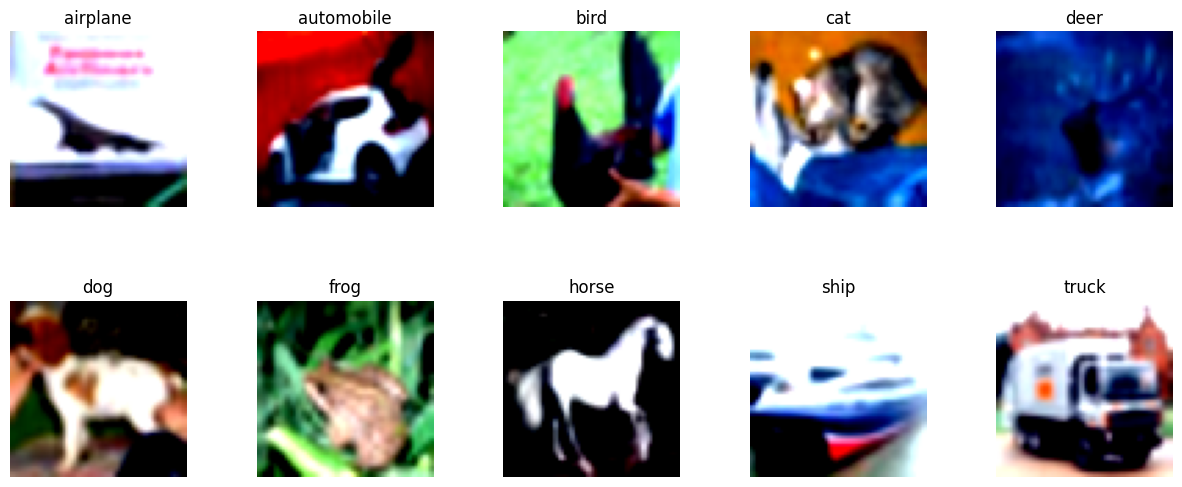

In [10]:
# Define the labels for each class
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a dictionary to store one random image for each class
random_images = {}

# Loop through the CIFAR-10 dataset to find one random image for each class
for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    class_name = labels[label]
    if class_name not in random_images:
        random_images[class_name] = image
        if len(random_images) == 10:
            break

# Display the random images for each class
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labels):
    row = i // 5
    col = i % 5
    image = random_images[label]
    # Normalize the image data
    image = image / 2 + 0.5
    image = np.clip(image, 0, 1) # Clip the pixel values to [0, 1] range
    image = np.transpose(image.numpy(), (1, 2, 0))
    axs[row, col].imshow(image)
    axs[row, col].set_title(label)
    axs[row, col].axis('off')
plt.show()


In [11]:

# Split the train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


In [12]:
print("train images :"+str(len(train_dataset)))
print("validation images :"+str(len(val_dataset)))
print("test images :"+str(len(test_dataset)))



train images :40000
validation images :10000
test images :10000


In [12]:
# Initialize or Define the model 

model = VisionTransformer(image_size=image_size,in_channels=in_channels,patch_size=patch_size,embed_dim=dim,depth=depth,num_heads=heads,mlp_ratio=mlp_ratio,num_classes=num_classes)



In [13]:
#Define the loss function
criterion = nn.CrossEntropyLoss()

#  Define the optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-2)    # reduce overfitting

# Define the learning_rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define number of workers and GPUs
NUM_WORKERS = 4
NUM_GPUS = torch.cuda.device_count()
print(NUM_GPUS)

# CPU/GPU (device) training
model.to(device)



Using device: cuda
8


VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0): TransformerEncoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (qkv): Linear(in_features=64, out_features=192, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=64, out_features=256, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=256, out_features=64, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHead

In [17]:

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)




In [16]:


# # Train the model
train_losses = []
val_losses = []
train_accs = []
val_accs = []

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss = 0
    train_acc = 0
    for images, labels in train_loader:
        # Move input tensor to GPU
        images = images.to(device)
        labels = labels.to(device)
        # Zero out gradients
        optimizer.zero_grad()
         # Forward pass
        output = model(images)
        # Calculate loss
        loss = criterion(output, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()   # GPU
        #xm.optimizer_step(optimizer)   # TPU
        
        # Update the learning rate
        scheduler.step()
        
        # Compute training statistics
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == labels).sum().item()
    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate the model on validation data
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # Move input tensor to GPU
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = nn.CrossEntropyLoss()(output, labels)
            val_loss += loss.item()
            val_acc += (output.argmax(dim=1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: train loss={train_loss:.4f}, train acc={train_acc:.4f}, val loss={val_loss:.4f}, val acc={val_acc:.4f}")
    
    # epoch time calculation
    epoch_end_time = time.time()
    epoch_training_time = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch+1} Training time: {epoch_training_time} seconds")
    print('\n')


# training time    
end_time = time.time()
training_time = end_time - start_time
print(f"Total Training time: {seconds_to_hms(training_time)}")
print('\n')    



Epoch 1: train loss=1.8794, train acc=0.2956, val loss=1.7724, val acc=0.3454
Epoch 1 Training time: 22.054325103759766 seconds


Epoch 2: train loss=1.6248, train acc=0.4027, val loss=1.5044, val acc=0.4532
Epoch 2 Training time: 20.600298166275024 seconds


Epoch 3: train loss=1.4738, train acc=0.4620, val loss=1.3629, val acc=0.5086
Epoch 3 Training time: 20.48371458053589 seconds


Epoch 4: train loss=1.3414, train acc=0.5165, val loss=1.3511, val acc=0.5077
Epoch 4 Training time: 20.47887110710144 seconds


Epoch 5: train loss=1.2520, train acc=0.5497, val loss=1.3193, val acc=0.5220
Epoch 5 Training time: 20.428321361541748 seconds


Epoch 6: train loss=1.2037, train acc=0.5647, val loss=1.1831, val acc=0.5744
Epoch 6 Training time: 20.456116437911987 seconds


Epoch 7: train loss=1.1898, train acc=0.5707, val loss=1.1187, val acc=0.5988
Epoch 7 Training time: 20.457720279693604 seconds


Epoch 8: train loss=1.1402, train acc=0.5906, val loss=1.1379, val acc=0.5848
Epoch 8 Traini

Epoch 64: train loss=0.5814, train acc=0.7957, val loss=0.8490, val acc=0.6968
Epoch 64 Training time: 20.423360109329224 seconds


Epoch 65: train loss=0.5759, train acc=0.7963, val loss=0.8299, val acc=0.7166
Epoch 65 Training time: 20.500477075576782 seconds


Epoch 66: train loss=0.6029, train acc=0.7878, val loss=0.7268, val acc=0.7481
Epoch 66 Training time: 20.395814657211304 seconds


Epoch 67: train loss=0.6033, train acc=0.7864, val loss=0.7256, val acc=0.7541
Epoch 67 Training time: 20.365923166275024 seconds


Epoch 68: train loss=0.5802, train acc=0.7943, val loss=0.7991, val acc=0.7216
Epoch 68 Training time: 20.41690945625305 seconds


Epoch 69: train loss=0.5602, train acc=0.8022, val loss=0.8268, val acc=0.7130
Epoch 69 Training time: 20.3150794506073 seconds


Epoch 70: train loss=0.5670, train acc=0.7992, val loss=0.8045, val acc=0.7282
Epoch 70 Training time: 20.41233801841736 seconds


Epoch 71: train loss=0.5939, train acc=0.7888, val loss=0.7189, val acc=0.7522
E

Epoch 126: train loss=0.4377, train acc=0.8430, val loss=0.6910, val acc=0.7708
Epoch 126 Training time: 20.42259669303894 seconds


Epoch 127: train loss=0.4435, train acc=0.8405, val loss=0.7225, val acc=0.7611
Epoch 127 Training time: 20.390259981155396 seconds


Epoch 128: train loss=0.4152, train acc=0.8515, val loss=0.7682, val acc=0.7505
Epoch 128 Training time: 20.400309324264526 seconds


Epoch 129: train loss=0.3997, train acc=0.8572, val loss=0.7900, val acc=0.7391
Epoch 129 Training time: 20.403905868530273 seconds


Epoch 130: train loss=0.4206, train acc=0.8517, val loss=0.7392, val acc=0.7654
Epoch 130 Training time: 20.38527202606201 seconds


Epoch 131: train loss=0.4368, train acc=0.8450, val loss=0.7019, val acc=0.7710
Epoch 131 Training time: 20.36214852333069 seconds


Epoch 132: train loss=0.4228, train acc=0.8496, val loss=0.7120, val acc=0.7624
Epoch 132 Training time: 20.37271547317505 seconds


Epoch 133: train loss=0.3980, train acc=0.8596, val loss=0.8112, v

Epoch 188: train loss=0.3218, train acc=0.8857, val loss=0.7745, val acc=0.7544
Epoch 188 Training time: 20.479546785354614 seconds


Epoch 189: train loss=0.3064, train acc=0.8901, val loss=0.7673, val acc=0.7583
Epoch 189 Training time: 20.458224534988403 seconds


Epoch 190: train loss=0.3430, train acc=0.8779, val loss=0.7021, val acc=0.7793
Epoch 190 Training time: 20.446338891983032 seconds


Epoch 191: train loss=0.3613, train acc=0.8719, val loss=0.6825, val acc=0.7826
Epoch 191 Training time: 20.503942251205444 seconds


Epoch 192: train loss=0.3400, train acc=0.8798, val loss=0.7264, val acc=0.7595
Epoch 192 Training time: 20.51523470878601 seconds


Epoch 193: train loss=0.3096, train acc=0.8922, val loss=0.8026, val acc=0.7459
Epoch 193 Training time: 20.38763117790222 seconds


Epoch 194: train loss=0.3144, train acc=0.8875, val loss=0.7648, val acc=0.7661
Epoch 194 Training time: 20.379724502563477 seconds


Epoch 195: train loss=0.3445, train acc=0.8771, val loss=0.6936,

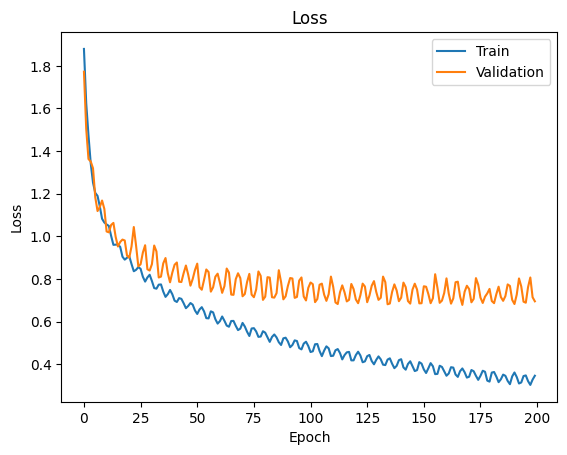

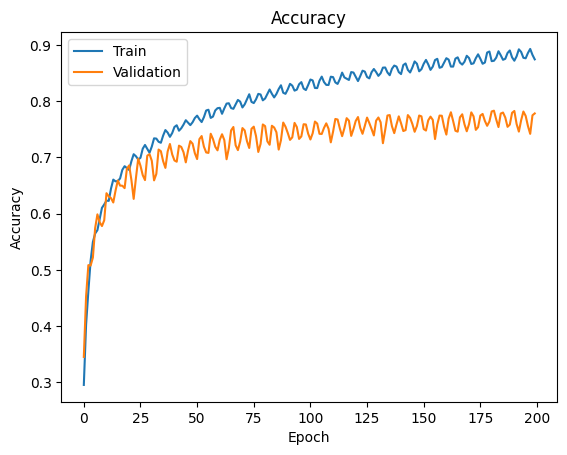

In [17]:

# Plot the training and validation loss
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [18]:
# Set the model to evaluation mode
model.eval()


# Evaluate the model on train data
train_acc = 0
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        train_acc += (output.argmax(dim=1) == labels).sum().item()
train_acc /= len(train_loader.dataset)
print(f"Train accuracy: {train_acc:.4f}")

# Evaluate the model on test data
test_acc = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        test_acc += (output.argmax(dim=1) == labels).sum().item()
test_acc /= len(test_loader.dataset)
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9451
Test accuracy: 0.8022


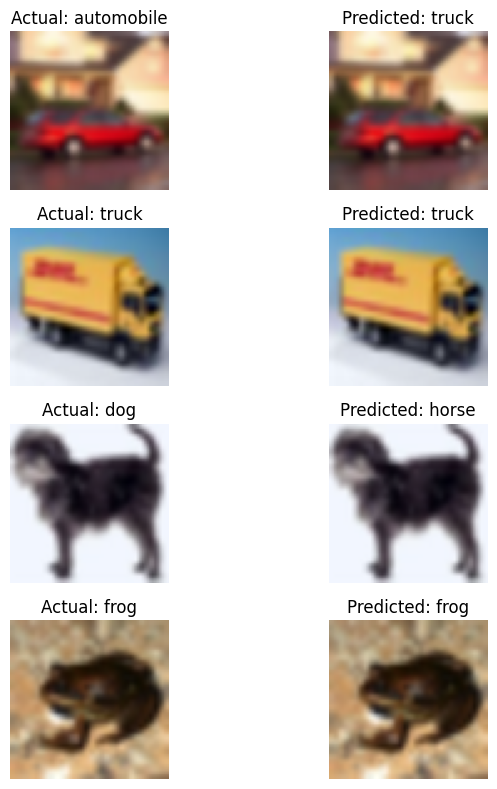

In [19]:
# Set the model to evaluation mode
model.eval()

# Select five random samples from the test data
num_samples = 4
sample_indices = np.random.randint(len(test_loader.dataset), size=num_samples)
samples = [test_loader.dataset[i] for i in sample_indices]

# Make predictions for each sample and plot the results
fig, axs = plt.subplots(nrows=num_samples, ncols=2, figsize=(8, 2*num_samples))

for i, (image, label) in enumerate(samples):
    
    image = image.to(device)
    label = torch.tensor(label).to(device)

    # Make prediction using the trained model
    output = model(image.unsqueeze(0))
    predicted_label = output.argmax(dim=1).item()

    # Normalize the image data to [0, 1] range
    image = image.cpu().permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())

    # Plot the image and the actual and predicted class labels
    axs[i, 0].imshow(image)
    axs[i, 0].set_title(f"Actual: {test_loader.dataset.classes[label]}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(image)
    axs[i, 1].set_title(f"Predicted: {test_loader.dataset.classes[predicted_label]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


## (c) Using different patch_size (non-overlapping patches).

### (ii) With patch_size = 8x8 (using a constant number of heads : heads = 8)

In [20]:

# Hyperparameters
image_size = 64
patch_size = 8
num_classes = 10
in_channels = 3
dim = 64  # hidden_dim
depth = 4
heads = 8
mlp_ratio = 4 # (embed dim * 4) = mlp_dim, if dim = 768, then mlp_dim = 3072
batch_size = 128
num_epochs = 200
learning_rate = 1e-3



In [21]:
# Initialize or Define the model 

model = VisionTransformer(image_size=image_size,in_channels=in_channels,patch_size=patch_size,embed_dim=dim,depth=depth,num_heads=heads,mlp_ratio=mlp_ratio,num_classes=num_classes)


In [22]:
#Define the loss function
criterion = nn.CrossEntropyLoss()

#  Define the optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-2)

# Define the learning_rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define number of workers and GPUs
NUM_WORKERS = 8
NUM_GPUS = torch.cuda.device_count()
print(NUM_GPUS)

# CPU/GPU (device) training
model.to(device)




Using device: cuda
8


VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 64, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0): TransformerEncoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (qkv): Linear(in_features=64, out_features=192, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=64, out_features=256, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=256, out_features=64, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHead

In [24]:


# # Train the model
train_losses = []
val_losses = []
train_accs = []
val_accs = []

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss = 0
    train_acc = 0
    for images, labels in train_loader:
        # Move input tensor to GPU
        images = images.to(device)
        labels = labels.to(device)
        # Zero out gradients
        optimizer.zero_grad()
         # Forward pass
        output = model(images)
        # Calculate loss
        loss = criterion(output, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()   # GPU
        #xm.optimizer_step(optimizer)   # TPU
        
        # Update the learning rate
        scheduler.step()
        
        # Compute training statistics
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == labels).sum().item()
    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate the model on validation data
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # Move input tensor to GPU
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = nn.CrossEntropyLoss()(output, labels)
            val_loss += loss.item()
            val_acc += (output.argmax(dim=1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: train loss={train_loss:.4f}, train acc={train_acc:.4f}, val loss={val_loss:.4f}, val acc={val_acc:.4f}")
    
    # epoch time calculation
    epoch_end_time = time.time()
    epoch_training_time = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch+1} Training time: {epoch_training_time} seconds")
    print('\n')


# training time    
end_time = time.time()
training_time = end_time - start_time
print(f"Total Training time: {seconds_to_hms(training_time)}")
print('\n')    



Epoch 1: train loss=1.8531, train acc=0.3103, val loss=1.7651, val acc=0.3458
Epoch 1 Training time: 7.544731140136719 seconds


Epoch 2: train loss=1.6777, train acc=0.3763, val loss=1.5679, val acc=0.4262
Epoch 2 Training time: 7.266322135925293 seconds


Epoch 3: train loss=1.5678, train acc=0.4244, val loss=1.4947, val acc=0.4475
Epoch 3 Training time: 7.646501064300537 seconds


Epoch 4: train loss=1.4522, train acc=0.4713, val loss=1.4226, val acc=0.4866
Epoch 4 Training time: 7.34216570854187 seconds


Epoch 5: train loss=1.3626, train acc=0.5067, val loss=1.3980, val acc=0.4954
Epoch 5 Training time: 7.19475531578064 seconds


Epoch 6: train loss=1.3208, train acc=0.5238, val loss=1.2820, val acc=0.5353
Epoch 6 Training time: 7.306171894073486 seconds


Epoch 7: train loss=1.2861, train acc=0.5359, val loss=1.2291, val acc=0.5494
Epoch 7 Training time: 7.090775728225708 seconds


Epoch 8: train loss=1.2370, train acc=0.5541, val loss=1.2421, val acc=0.5463
Epoch 8 Training time

Epoch 64: train loss=0.6391, train acc=0.7717, val loss=0.8852, val acc=0.6937
Epoch 64 Training time: 7.5332841873168945 seconds


Epoch 65: train loss=0.6333, train acc=0.7749, val loss=0.8899, val acc=0.6873
Epoch 65 Training time: 7.583158731460571 seconds


Epoch 66: train loss=0.6551, train acc=0.7677, val loss=0.8120, val acc=0.7200
Epoch 66 Training time: 7.303437232971191 seconds


Epoch 67: train loss=0.6605, train acc=0.7648, val loss=0.8081, val acc=0.7203
Epoch 67 Training time: 7.1398162841796875 seconds


Epoch 68: train loss=0.6329, train acc=0.7754, val loss=0.8466, val acc=0.7064
Epoch 68 Training time: 7.285915374755859 seconds


Epoch 69: train loss=0.6128, train acc=0.7826, val loss=0.8765, val acc=0.6992
Epoch 69 Training time: 7.076291561126709 seconds


Epoch 70: train loss=0.6249, train acc=0.7766, val loss=0.8521, val acc=0.7085
Epoch 70 Training time: 7.449431419372559 seconds


Epoch 71: train loss=0.6418, train acc=0.7712, val loss=0.7984, val acc=0.7200
Ep

Epoch 127: train loss=0.5029, train acc=0.8206, val loss=0.8162, val acc=0.7271
Epoch 127 Training time: 7.160556077957153 seconds


Epoch 128: train loss=0.4781, train acc=0.8289, val loss=0.8476, val acc=0.7172
Epoch 128 Training time: 7.16562032699585 seconds


Epoch 129: train loss=0.4639, train acc=0.8337, val loss=0.8483, val acc=0.7155
Epoch 129 Training time: 7.269654035568237 seconds


Epoch 130: train loss=0.4848, train acc=0.8257, val loss=0.8224, val acc=0.7327
Epoch 130 Training time: 7.244847297668457 seconds


Epoch 131: train loss=0.5048, train acc=0.8204, val loss=0.8084, val acc=0.7331
Epoch 131 Training time: 7.258008003234863 seconds


Epoch 132: train loss=0.4921, train acc=0.8243, val loss=0.8169, val acc=0.7232
Epoch 132 Training time: 7.516397476196289 seconds


Epoch 133: train loss=0.4617, train acc=0.8375, val loss=0.8748, val acc=0.7065
Epoch 133 Training time: 7.307648420333862 seconds


Epoch 134: train loss=0.4673, train acc=0.8330, val loss=0.8647, val a

Epoch 189: train loss=0.3944, train acc=0.8593, val loss=0.8570, val acc=0.7201
Epoch 189 Training time: 7.810073137283325 seconds


Epoch 190: train loss=0.4258, train acc=0.8480, val loss=0.8344, val acc=0.7333
Epoch 190 Training time: 7.553613662719727 seconds


Epoch 191: train loss=0.4366, train acc=0.8420, val loss=0.8297, val acc=0.7320
Epoch 191 Training time: 7.706427812576294 seconds


Epoch 192: train loss=0.4133, train acc=0.8517, val loss=0.8191, val acc=0.7264
Epoch 192 Training time: 7.342034101486206 seconds


Epoch 193: train loss=0.3906, train acc=0.8601, val loss=0.8908, val acc=0.7111
Epoch 193 Training time: 7.139287710189819 seconds


Epoch 194: train loss=0.4018, train acc=0.8556, val loss=0.8608, val acc=0.7296
Epoch 194 Training time: 7.132798194885254 seconds


Epoch 195: train loss=0.4264, train acc=0.8480, val loss=0.8163, val acc=0.7407
Epoch 195 Training time: 7.57696008682251 seconds


Epoch 196: train loss=0.4228, train acc=0.8470, val loss=0.8208, val a

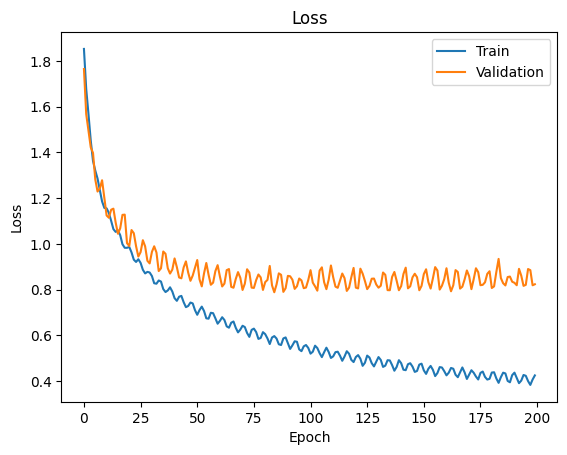

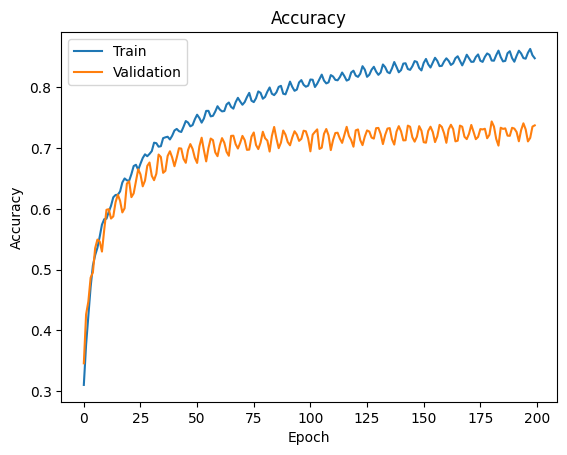

In [25]:

# Plot the training and validation loss
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [26]:
# Set the model to evaluation mode
model.eval()


# Evaluate the model on train data
train_acc = 0
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        train_acc += (output.argmax(dim=1) == labels).sum().item()
train_acc /= len(train_loader.dataset)
print(f"Train accuracy: {train_acc:.4f}")

# Evaluate the model on test data
test_acc = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        test_acc += (output.argmax(dim=1) == labels).sum().item()
test_acc /= len(test_loader.dataset)
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9390
Test accuracy: 0.7748


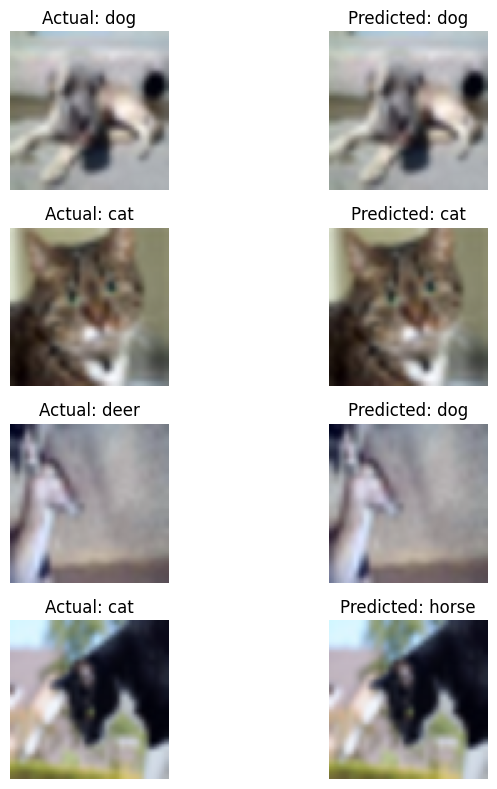

In [27]:
# Set the model to evaluation mode
model.eval()

# Select five random samples from the test data
num_samples = 4
sample_indices = np.random.randint(len(test_loader.dataset), size=num_samples)
samples = [test_loader.dataset[i] for i in sample_indices]

# Make predictions for each sample and plot the results
fig, axs = plt.subplots(nrows=num_samples, ncols=2, figsize=(8, 2*num_samples))

for i, (image, label) in enumerate(samples):
    
    image = image.to(device)
    label = torch.tensor(label).to(device)

    # Make prediction using the trained model
    output = model(image.unsqueeze(0))
    predicted_label = output.argmax(dim=1).item()

    # Normalize the image data to [0, 1] range
    image = image.cpu().permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())

    # Plot the image and the actual and predicted class labels
    axs[i, 0].imshow(image)
    axs[i, 0].set_title(f"Actual: {test_loader.dataset.classes[label]}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(image)
    axs[i, 1].set_title(f"Predicted: {test_loader.dataset.classes[predicted_label]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


### (iii) With patch_size = 16x16 (using a constant number of heads : heads = 8)

In [28]:

# Hyperparameters
image_size = 64
patch_size = 16
num_classes = 10
in_channels = 3
dim = 64  # hidden_dim
depth = 4
heads = 8
mlp_ratio = 4 # (embed dim * 4) = mlp_dim, if dim = 768, then mlp_dim = 3072
batch_size = 128
num_epochs = 200
learning_rate = 1e-3



In [29]:
# Initialize or Define the model 

model = VisionTransformer(image_size=image_size,in_channels=in_channels,patch_size=patch_size,embed_dim=dim,depth=depth,num_heads=heads,mlp_ratio=mlp_ratio,num_classes=num_classes)



In [30]:
#Define the loss function
criterion = nn.CrossEntropyLoss()

#  Define the optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-2)

# Define the learning_rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define number of workers and GPUs
NUM_WORKERS = 8
NUM_GPUS = torch.cuda.device_count()
print(NUM_GPUS)

# CPU/GPU (device) training
model.to(device)



Using device: cuda
8


VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 64, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0): TransformerEncoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (qkv): Linear(in_features=64, out_features=192, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=64, out_features=256, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=256, out_features=64, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): Multi

In [32]:


# # Train the model
train_losses = []
val_losses = []
train_accs = []
val_accs = []

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss = 0
    train_acc = 0
    for images, labels in train_loader:
        # Move input tensor to GPU
        images = images.to(device)
        labels = labels.to(device)
        # Zero out gradients
        optimizer.zero_grad()
         # Forward pass
        output = model(images)
        # Calculate loss
        loss = criterion(output, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()   # GPU
        #xm.optimizer_step(optimizer)   # TPU
        
        # Update the learning rate
        scheduler.step()
        
        # Compute training statistics
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == labels).sum().item()
    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate the model on validation data
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # Move input tensor to GPU
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = nn.CrossEntropyLoss()(output, labels)
            val_loss += loss.item()
            val_acc += (output.argmax(dim=1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: train loss={train_loss:.4f}, train acc={train_acc:.4f}, val loss={val_loss:.4f}, val acc={val_acc:.4f}")
    
    # epoch time calculation
    epoch_end_time = time.time()
    epoch_training_time = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch+1} Training time: {epoch_training_time} seconds")
    print('\n')


# training time    
end_time = time.time()
training_time = end_time - start_time
print(f"Total Training time: {seconds_to_hms(training_time)}")
print('\n')    



Epoch 1: train loss=1.9135, train acc=0.2908, val loss=1.8241, val acc=0.3240
Epoch 1 Training time: 7.787019729614258 seconds


Epoch 2: train loss=1.7611, train acc=0.3508, val loss=1.6842, val acc=0.3845
Epoch 2 Training time: 7.743407487869263 seconds


Epoch 3: train loss=1.6817, train acc=0.3816, val loss=1.6246, val acc=0.4052
Epoch 3 Training time: 7.472726583480835 seconds


Epoch 4: train loss=1.6155, train acc=0.4105, val loss=1.6335, val acc=0.4061
Epoch 4 Training time: 7.470727920532227 seconds


Epoch 5: train loss=1.5700, train acc=0.4290, val loss=1.5825, val acc=0.4255
Epoch 5 Training time: 7.40143084526062 seconds


Epoch 6: train loss=1.5451, train acc=0.4392, val loss=1.5311, val acc=0.4418
Epoch 6 Training time: 7.283708572387695 seconds


Epoch 7: train loss=1.5201, train acc=0.4487, val loss=1.4834, val acc=0.4648
Epoch 7 Training time: 7.321691989898682 seconds


Epoch 8: train loss=1.4842, train acc=0.4595, val loss=1.4768, val acc=0.4646
Epoch 8 Training tim

Epoch 64: train loss=0.8981, train acc=0.6823, val loss=1.1520, val acc=0.5939
Epoch 64 Training time: 7.722222805023193 seconds


Epoch 65: train loss=0.8940, train acc=0.6813, val loss=1.1487, val acc=0.5958
Epoch 65 Training time: 7.046548366546631 seconds


Epoch 66: train loss=0.9209, train acc=0.6694, val loss=1.1068, val acc=0.6114
Epoch 66 Training time: 7.306370496749878 seconds


Epoch 67: train loss=0.9117, train acc=0.6740, val loss=1.1024, val acc=0.6140
Epoch 67 Training time: 7.320821285247803 seconds


Epoch 68: train loss=0.8874, train acc=0.6829, val loss=1.1220, val acc=0.6001
Epoch 68 Training time: 7.237786054611206 seconds


Epoch 69: train loss=0.8699, train acc=0.6896, val loss=1.1481, val acc=0.5929
Epoch 69 Training time: 7.295302629470825 seconds


Epoch 70: train loss=0.8823, train acc=0.6848, val loss=1.1148, val acc=0.6084
Epoch 70 Training time: 7.103566884994507 seconds


Epoch 71: train loss=0.8961, train acc=0.6818, val loss=1.0925, val acc=0.6141
Epoc

Epoch 127: train loss=0.7411, train acc=0.7352, val loss=1.1097, val acc=0.6297
Epoch 127 Training time: 7.685745000839233 seconds


Epoch 128: train loss=0.7149, train acc=0.7437, val loss=1.1531, val acc=0.6054
Epoch 128 Training time: 7.520637512207031 seconds


Epoch 129: train loss=0.7052, train acc=0.7477, val loss=1.1662, val acc=0.6069
Epoch 129 Training time: 7.3764660358428955 seconds


Epoch 130: train loss=0.7348, train acc=0.7377, val loss=1.0989, val acc=0.6292
Epoch 130 Training time: 7.654226779937744 seconds


Epoch 131: train loss=0.7424, train acc=0.7347, val loss=1.0968, val acc=0.6287
Epoch 131 Training time: 7.38819146156311 seconds


Epoch 132: train loss=0.7303, train acc=0.7405, val loss=1.1074, val acc=0.6207
Epoch 132 Training time: 7.533085584640503 seconds


Epoch 133: train loss=0.6982, train acc=0.7521, val loss=1.1688, val acc=0.6042
Epoch 133 Training time: 7.482309818267822 seconds


Epoch 134: train loss=0.7034, train acc=0.7485, val loss=1.1714, val 

Epoch 189: train loss=0.6237, train acc=0.7749, val loss=1.1753, val acc=0.6236
Epoch 189 Training time: 7.276297330856323 seconds


Epoch 190: train loss=0.6499, train acc=0.7671, val loss=1.1249, val acc=0.6275
Epoch 190 Training time: 7.194010972976685 seconds


Epoch 191: train loss=0.6656, train acc=0.7616, val loss=1.1171, val acc=0.6301
Epoch 191 Training time: 7.581061124801636 seconds


Epoch 192: train loss=0.6430, train acc=0.7700, val loss=1.1579, val acc=0.6219
Epoch 192 Training time: 7.528431177139282 seconds


Epoch 193: train loss=0.6190, train acc=0.7804, val loss=1.1940, val acc=0.6141
Epoch 193 Training time: 7.438902139663696 seconds


Epoch 194: train loss=0.6303, train acc=0.7748, val loss=1.1525, val acc=0.6196
Epoch 194 Training time: 7.323119401931763 seconds


Epoch 195: train loss=0.6601, train acc=0.7636, val loss=1.1270, val acc=0.6298
Epoch 195 Training time: 7.60187292098999 seconds


Epoch 196: train loss=0.6542, train acc=0.7670, val loss=1.1337, val a

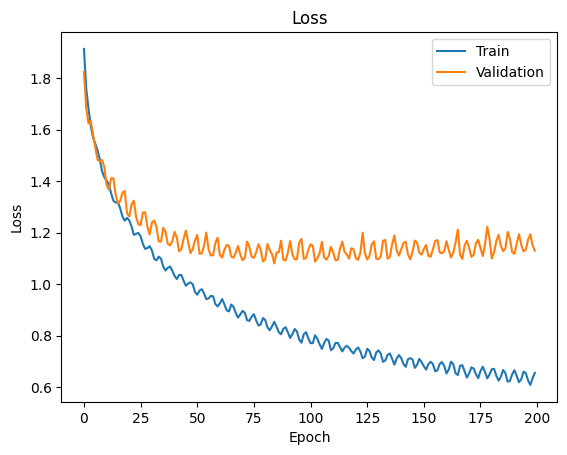

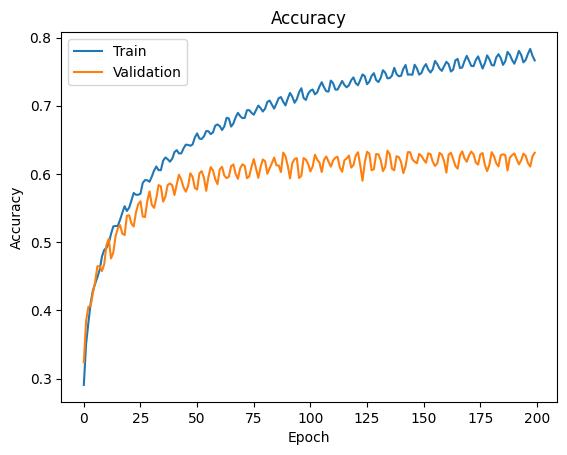

In [33]:

# Plot the training and validation loss
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [34]:
# Set the model to evaluation mode
model.eval()


# Evaluate the model on train data
train_acc = 0
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        train_acc += (output.argmax(dim=1) == labels).sum().item()
train_acc /= len(train_loader.dataset)
print(f"Train accuracy: {train_acc:.4f}")

# Evaluate the model on test data
test_acc = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        test_acc += (output.argmax(dim=1) == labels).sum().item()
test_acc /= len(test_loader.dataset)
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.8913
Test accuracy: 0.6801


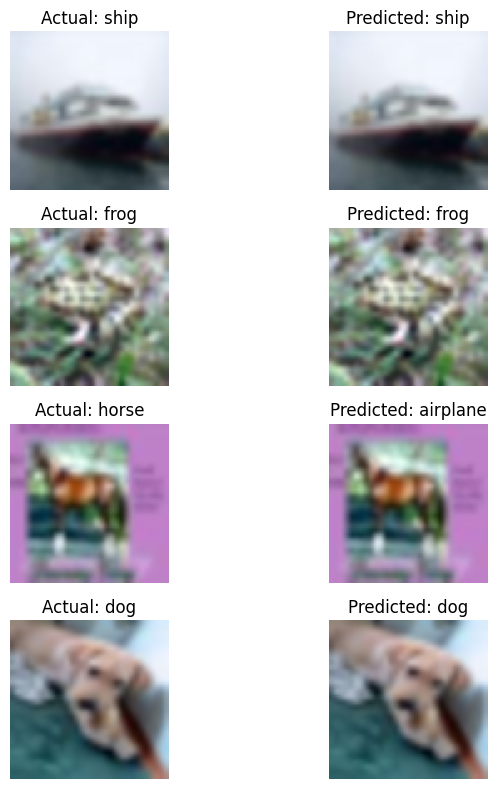

In [35]:
# Set the model to evaluation mode
model.eval()

# Select five random samples from the test data
num_samples = 4
sample_indices = np.random.randint(len(test_loader.dataset), size=num_samples)
samples = [test_loader.dataset[i] for i in sample_indices]

# Make predictions for each sample and plot the results
fig, axs = plt.subplots(nrows=num_samples, ncols=2, figsize=(8, 2*num_samples))

for i, (image, label) in enumerate(samples):
    
    image = image.to(device)
    label = torch.tensor(label).to(device)

    # Make prediction using the trained model
    output = model(image.unsqueeze(0))
    predicted_label = output.argmax(dim=1).item()

    # Normalize the image data to [0, 1] range
    image = image.cpu().permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())

    # Plot the image and the actual and predicted class labels
    axs[i, 0].imshow(image)
    axs[i, 0].set_title(f"Actual: {test_loader.dataset.classes[label]}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(image)
    axs[i, 1].set_title(f"Predicted: {test_loader.dataset.classes[predicted_label]}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


## (c) Using different patch_size (overlapping patches).

### (i) With patch_size = 4x4 (using a constant number of heads : heads = 8)

In [53]:

# Hyperparameters
image_size = 64
patch_size = 4
num_classes = 10
in_channels = 3
dim = 64  # hidden_dim
depth = 4
heads = 8
mlp_ratio = 4 # (embed dim * 4) = mlp_dim, if dim = 768, then mlp_dim = 3072
batch_size = 128
num_epochs = 200
learning_rate = 1e-3



In [54]:
# ViT
#  overlapping patches

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=in_channels, patch_size=patch_size, embed_dim=dim, stride=None):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        # overlapping with the stride value
        self.stride = stride if stride is not None else patch_size // 2  # Default stride is half of the patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=self.stride)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == W, "Input tensor must be square"
        num_patches = ((H - self.patch_size) // self.stride + 1) ** 2
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        return x



class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(0.1)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(0.1)

    def forward(self, x):
        B, N, E = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.head_dim ** -0.5
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = attn @ v
        x = x.transpose(1, 2).reshape(B, N, E)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio):
        super(TransformerEncoder, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        hidden_features = int(embed_dim * mlp_ratio)
        self.mlp = MLP(embed_dim, hidden_features, embed_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_size=image_size,
        in_channels=in_channels,  
        patch_size=patch_size,
        embed_dim=dim,
        depth=depth,
        num_heads=heads,
        mlp_ratio=mlp_ratio,
        num_classes=num_classes,
        stride=None,
    ):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, embed_dim, stride=stride)
        stride = stride if stride is not None else patch_size // 2
        num_patches = ((image_size - patch_size) // stride + 1) ** 2
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(0.1)

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(TransformerEncoder(embed_dim, num_heads, mlp_ratio))

        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        B, N, E = x.shape
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed[:, :N+1, :]
        x = self.pos_drop(x)
        
     # model does not use the CLS tokens from different layers of the model, 
    # but only from the output of the final layer for classification
        for layer in self.layers:
            x = layer(x)
    #Here, x[:, 0] selects the CLS token from the output sequence of the final transformer layer. This CLS token is then passed through a Layer Normalization (self.norm) 
    #and a linear transformation (self.fc) to get the logits for the classes.
        x = self.norm(x[:, 0])
        x = self.fc(x)
        return x





In [55]:
# Initialize or Define the model 

model = VisionTransformer(image_size=image_size,in_channels=in_channels,patch_size=patch_size,embed_dim=dim,depth=depth,num_heads=heads,mlp_ratio=mlp_ratio,num_classes=num_classes)



In [56]:
#Define the loss function
criterion = nn.CrossEntropyLoss()

#  Define the optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-2)

# Define the learning_rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [57]:
# # Initialize the distributed environment
# dist.init_process_group(backend="nccl", init_method="env://")
# rank = dist.get_rank()
# world_size = dist.get_world_size()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Define number of workers and GPUs
NUM_WORKERS = 4
NUM_GPUS = torch.cuda.device_count()
print(NUM_GPUS)

# CPU/GPU (device) training
model.to(device)

# Partition the model across GPUs using DataParallel
if NUM_GPUS > 1:
    model = DataParallel(model)

# Wrap the model with DistributedDataParallel to enable distributed training
#model = DDP(model, device_ids=[rank], output_device=rank)



Using device: cuda
8


In [24]:


# # Train the model
train_losses = []
val_losses = []
train_accs = []
val_accs = []

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss = 0
    train_acc = 0
    for images, labels in train_loader:
        # Move input tensor to GPU
        images = images.to(device)
        labels = labels.to(device)
        # Zero out gradients
        optimizer.zero_grad()
         # Forward pass
        output = model(images)
        # Calculate loss
        loss = criterion(output, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()   # GPU
        #xm.optimizer_step(optimizer)   # TPU
        
        # Update the learning rate
        scheduler.step()
        
        # Compute training statistics
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == labels).sum().item()
    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate the model on validation data
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # Move input tensor to GPU
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = nn.CrossEntropyLoss()(output, labels)
            val_loss += loss.item()
            val_acc += (output.argmax(dim=1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: train loss={train_loss:.4f}, train acc={train_acc:.4f}, val loss={val_loss:.4f}, val acc={val_acc:.4f}")
    
    # epoch time calculation
    epoch_end_time = time.time()
    epoch_training_time = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch+1} Training time: {epoch_training_time} seconds")
    print('\n')


# training time    
end_time = time.time()
training_time = end_time - start_time
print(f"Total Training time: {seconds_to_hms(training_time)}")
print('\n')    

# Clean up the process group
#dist.destroy_process_group()

Epoch 1: train loss=1.8572, train acc=0.3099, val loss=1.7698, val acc=0.3369
Epoch 1 Training time: 47.298277378082275 seconds


Epoch 2: train loss=1.6352, train acc=0.3956, val loss=1.5364, val acc=0.4259
Epoch 2 Training time: 46.566137075424194 seconds


Epoch 3: train loss=1.5078, train acc=0.4470, val loss=1.4025, val acc=0.4896
Epoch 3 Training time: 46.628156661987305 seconds


Epoch 4: train loss=1.3732, train acc=0.5026, val loss=1.4128, val acc=0.4808
Epoch 4 Training time: 47.11892127990723 seconds


Epoch 5: train loss=1.2556, train acc=0.5470, val loss=1.3335, val acc=0.5150
Epoch 5 Training time: 46.61566948890686 seconds


Epoch 6: train loss=1.1970, train acc=0.5696, val loss=1.1685, val acc=0.5816
Epoch 6 Training time: 45.94151592254639 seconds


Epoch 7: train loss=1.1645, train acc=0.5827, val loss=1.1077, val acc=0.6055
Epoch 7 Training time: 47.77123546600342 seconds


Epoch 8: train loss=1.1085, train acc=0.6048, val loss=1.1210, val acc=0.5953
Epoch 8 Training

Epoch 64: train loss=0.4942, train acc=0.8275, val loss=0.7421, val acc=0.7438
Epoch 64 Training time: 45.84101748466492 seconds


Epoch 65: train loss=0.4852, train acc=0.8292, val loss=0.7534, val acc=0.7457
Epoch 65 Training time: 47.33988285064697 seconds


Epoch 66: train loss=0.5086, train acc=0.8203, val loss=0.6638, val acc=0.7786
Epoch 66 Training time: 48.22298789024353 seconds


Epoch 67: train loss=0.5142, train acc=0.8197, val loss=0.6736, val acc=0.7707
Epoch 67 Training time: 47.9038188457489 seconds


Epoch 68: train loss=0.5020, train acc=0.8229, val loss=0.7085, val acc=0.7601
Epoch 68 Training time: 45.78127908706665 seconds


Epoch 69: train loss=0.4636, train acc=0.8370, val loss=0.7615, val acc=0.7413
Epoch 69 Training time: 46.105971813201904 seconds


Epoch 70: train loss=0.4812, train acc=0.8296, val loss=0.7152, val acc=0.7571
Epoch 70 Training time: 47.80550765991211 seconds


Epoch 71: train loss=0.5031, train acc=0.8228, val loss=0.6586, val acc=0.7785
Epoc

Epoch 127: train loss=0.3772, train acc=0.8659, val loss=0.6729, val acc=0.7825
Epoch 127 Training time: 46.37986969947815 seconds


Epoch 128: train loss=0.3466, train acc=0.8784, val loss=0.7122, val acc=0.7645
Epoch 128 Training time: 47.38927721977234 seconds


Epoch 129: train loss=0.3266, train acc=0.8863, val loss=0.7505, val acc=0.7638
Epoch 129 Training time: 47.692826986312866 seconds


Epoch 130: train loss=0.3486, train acc=0.8753, val loss=0.7072, val acc=0.7743
Epoch 130 Training time: 47.81454634666443 seconds


Epoch 131: train loss=0.3717, train acc=0.8691, val loss=0.6378, val acc=0.7956
Epoch 131 Training time: 47.7604546546936 seconds


Epoch 132: train loss=0.3575, train acc=0.8718, val loss=0.6698, val acc=0.7822
Epoch 132 Training time: 47.66816020011902 seconds


Epoch 133: train loss=0.3304, train acc=0.8843, val loss=0.7465, val acc=0.7599
Epoch 133 Training time: 47.9955575466156 seconds


Epoch 134: train loss=0.3369, train acc=0.8802, val loss=0.7116, val a

Epoch 189: train loss=0.2653, train acc=0.9054, val loss=0.7538, val acc=0.7695
Epoch 189 Training time: 48.11622476577759 seconds


Epoch 190: train loss=0.2968, train acc=0.8943, val loss=0.6668, val acc=0.7966
Epoch 190 Training time: 48.18685984611511 seconds


Epoch 191: train loss=0.3065, train acc=0.8893, val loss=0.6570, val acc=0.7999
Epoch 191 Training time: 48.06910228729248 seconds


Epoch 192: train loss=0.2913, train acc=0.8950, val loss=0.6996, val acc=0.7793
Epoch 192 Training time: 48.49580955505371 seconds


Epoch 193: train loss=0.2657, train acc=0.9052, val loss=0.7804, val acc=0.7644
Epoch 193 Training time: 48.200685024261475 seconds


Epoch 194: train loss=0.2707, train acc=0.9035, val loss=0.7265, val acc=0.7763
Epoch 194 Training time: 48.17375087738037 seconds


Epoch 195: train loss=0.2977, train acc=0.8949, val loss=0.6582, val acc=0.7983
Epoch 195 Training time: 48.627479553222656 seconds


Epoch 196: train loss=0.3038, train acc=0.8926, val loss=0.6724, va

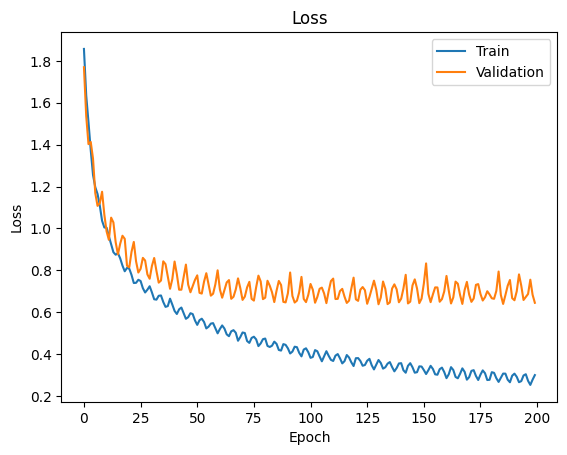

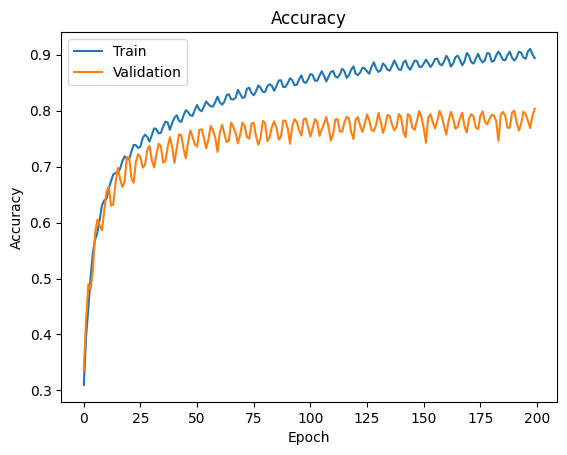

In [25]:

# Plot the training and validation loss
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [26]:
# Set the model to evaluation mode
model.eval()


# Evaluate the model on train data
train_acc = 0
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        train_acc += (output.argmax(dim=1) == labels).sum().item()
train_acc /= len(train_loader.dataset)
print(f"Train accuracy: {train_acc:.4f}")

# Evaluate the model on test data
test_acc = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        test_acc += (output.argmax(dim=1) == labels).sum().item()
test_acc /= len(test_loader.dataset)
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9535
Test accuracy: 0.8089


### (ii) With patch_size = 8x8 (using a constant number of heads : heads = 8)

In [27]:

# Hyperparameters
image_size = 64
patch_size = 8
num_classes = 10
in_channels = 3
dim = 64  # hidden_dim
depth = 4
heads = 8
mlp_ratio = 4 # (embed dim * 4) = mlp_dim, if dim = 768, then mlp_dim = 3072
batch_size = 128
num_epochs = 200
learning_rate = 1e-3



In [28]:
# Initialize or Define the model 

model = VisionTransformer(image_size=image_size,in_channels=in_channels,patch_size=patch_size,embed_dim=dim,depth=depth,num_heads=heads,mlp_ratio=mlp_ratio,num_classes=num_classes)



In [29]:
#Define the loss function
criterion = nn.CrossEntropyLoss()

#  Define the optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-2)

# Define the learning_rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Define number of workers and GPUs
NUM_WORKERS = 4
NUM_GPUS = torch.cuda.device_count()
print(NUM_GPUS)

# CPU/GPU (device) training
model.to(device)

# Partition the model across GPUs using DataParallel
if NUM_GPUS > 1:
    model = DataParallel(model)

# Wrap the model with DistributedDataParallel to enable distributed training
#model = DDP(model)



Using device: cuda
8


In [31]:


# # Train the model
train_losses = []
val_losses = []
train_accs = []
val_accs = []

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss = 0
    train_acc = 0
    for images, labels in train_loader:
        # Move input tensor to GPU
        images = images.to(device)
        labels = labels.to(device)
        # Zero out gradients
        optimizer.zero_grad()
         # Forward pass
        output = model(images)
        # Calculate loss
        loss = criterion(output, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()   # GPU
        #xm.optimizer_step(optimizer)   # TPU
        
        # Update the learning rate
        scheduler.step()
        
        # Compute training statistics
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == labels).sum().item()
    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate the model on validation data
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # Move input tensor to GPU
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = nn.CrossEntropyLoss()(output, labels)
            val_loss += loss.item()
            val_acc += (output.argmax(dim=1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: train loss={train_loss:.4f}, train acc={train_acc:.4f}, val loss={val_loss:.4f}, val acc={val_acc:.4f}")
    
    # epoch time calculation
    epoch_end_time = time.time()
    epoch_training_time = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch+1} Training time: {epoch_training_time} seconds")
    print('\n')


# training time    
end_time = time.time()
training_time = end_time - start_time
print(f"Total Training time: {seconds_to_hms(training_time)}")
print('\n')    



Epoch 1: train loss=1.7974, train acc=0.3303, val loss=1.7253, val acc=0.3455
Epoch 1 Training time: 22.24010968208313 seconds


Epoch 2: train loss=1.5970, train acc=0.4123, val loss=1.4843, val acc=0.4585
Epoch 2 Training time: 21.935285806655884 seconds


Epoch 3: train loss=1.4676, train acc=0.4671, val loss=1.3670, val acc=0.5082
Epoch 3 Training time: 21.888688564300537 seconds


Epoch 4: train loss=1.3479, train acc=0.5117, val loss=1.3980, val acc=0.4917
Epoch 4 Training time: 21.67158603668213 seconds


Epoch 5: train loss=1.2591, train acc=0.5454, val loss=1.3190, val acc=0.5141
Epoch 5 Training time: 22.174569129943848 seconds


Epoch 6: train loss=1.2151, train acc=0.5625, val loss=1.1983, val acc=0.5653
Epoch 6 Training time: 21.991862297058105 seconds


Epoch 7: train loss=1.1963, train acc=0.5687, val loss=1.1307, val acc=0.5940
Epoch 7 Training time: 21.69734811782837 seconds


Epoch 8: train loss=1.1390, train acc=0.5898, val loss=1.1923, val acc=0.5614
Epoch 8 Trainin

Epoch 64: train loss=0.5354, train acc=0.8110, val loss=0.7592, val acc=0.7388
Epoch 64 Training time: 21.788447380065918 seconds


Epoch 65: train loss=0.5309, train acc=0.8134, val loss=0.7478, val acc=0.7461
Epoch 65 Training time: 21.755094051361084 seconds


Epoch 66: train loss=0.5609, train acc=0.8031, val loss=0.6862, val acc=0.7681
Epoch 66 Training time: 21.89464497566223 seconds


Epoch 67: train loss=0.5585, train acc=0.8031, val loss=0.6719, val acc=0.7718
Epoch 67 Training time: 22.18811273574829 seconds


Epoch 68: train loss=0.5348, train acc=0.8095, val loss=0.7439, val acc=0.7445
Epoch 68 Training time: 21.60348343849182 seconds


Epoch 69: train loss=0.5159, train acc=0.8168, val loss=0.7747, val acc=0.7357
Epoch 69 Training time: 22.002436637878418 seconds


Epoch 70: train loss=0.5233, train acc=0.8143, val loss=0.7075, val acc=0.7577
Epoch 70 Training time: 21.730194807052612 seconds


Epoch 71: train loss=0.5462, train acc=0.8059, val loss=0.6750, val acc=0.7685


Epoch 126: train loss=0.4142, train acc=0.8537, val loss=0.6265, val acc=0.7927
Epoch 126 Training time: 21.97113060951233 seconds


Epoch 127: train loss=0.4145, train acc=0.8527, val loss=0.6586, val acc=0.7864
Epoch 127 Training time: 22.203181982040405 seconds


Epoch 128: train loss=0.3840, train acc=0.8651, val loss=0.7038, val acc=0.7642
Epoch 128 Training time: 21.48523473739624 seconds


Epoch 129: train loss=0.3645, train acc=0.8714, val loss=0.7018, val acc=0.7692
Epoch 129 Training time: 21.923023223876953 seconds


Epoch 130: train loss=0.3912, train acc=0.8611, val loss=0.6472, val acc=0.7883
Epoch 130 Training time: 21.807417392730713 seconds


Epoch 131: train loss=0.4089, train acc=0.8553, val loss=0.6335, val acc=0.7890
Epoch 131 Training time: 22.348078966140747 seconds


Epoch 132: train loss=0.3958, train acc=0.8586, val loss=0.6560, val acc=0.7764
Epoch 132 Training time: 21.961304903030396 seconds


Epoch 133: train loss=0.3710, train acc=0.8680, val loss=0.7108,

Epoch 188: train loss=0.3029, train acc=0.8928, val loss=0.7239, val acc=0.7693
Epoch 188 Training time: 22.420377254486084 seconds


Epoch 189: train loss=0.3003, train acc=0.8931, val loss=0.7112, val acc=0.7775
Epoch 189 Training time: 22.252082347869873 seconds


Epoch 190: train loss=0.3176, train acc=0.8876, val loss=0.6373, val acc=0.8000
Epoch 190 Training time: 21.6850848197937 seconds


Epoch 191: train loss=0.3360, train acc=0.8790, val loss=0.6373, val acc=0.7989
Epoch 191 Training time: 22.37508225440979 seconds


Epoch 192: train loss=0.3128, train acc=0.8899, val loss=0.6681, val acc=0.7792
Epoch 192 Training time: 22.227964162826538 seconds


Epoch 193: train loss=0.2929, train acc=0.8942, val loss=0.7359, val acc=0.7653
Epoch 193 Training time: 21.886889934539795 seconds


Epoch 194: train loss=0.2953, train acc=0.8935, val loss=0.6805, val acc=0.7931
Epoch 194 Training time: 22.247663259506226 seconds


Epoch 195: train loss=0.3330, train acc=0.8801, val loss=0.6173, 

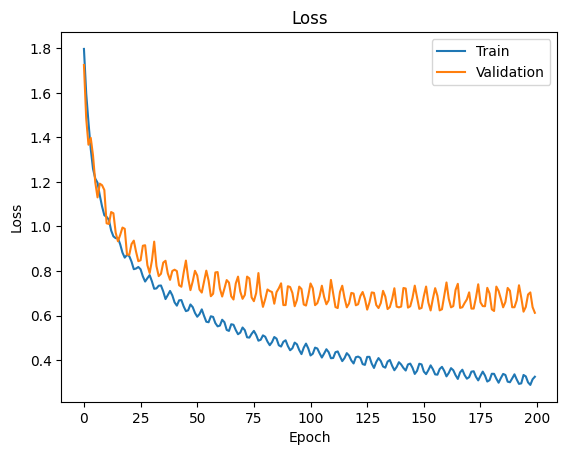

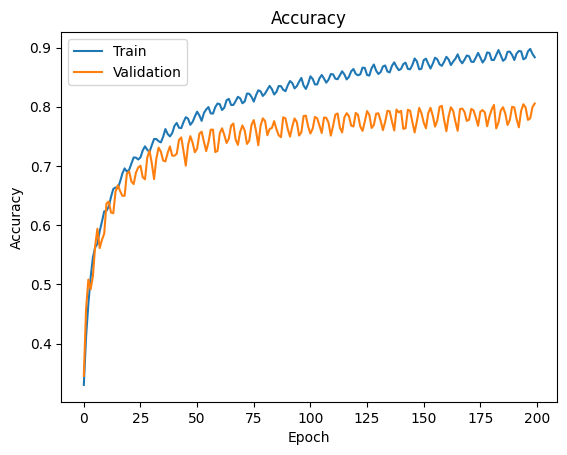

In [32]:

# Plot the training and validation loss
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [33]:
# Set the model to evaluation mode
model.eval()


# Evaluate the model on train data
train_acc = 0
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        train_acc += (output.argmax(dim=1) == labels).sum().item()
train_acc /= len(train_loader.dataset)
print(f"Train accuracy: {train_acc:.4f}")

# Evaluate the model on test data
test_acc = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        test_acc += (output.argmax(dim=1) == labels).sum().item()
test_acc /= len(test_loader.dataset)
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9524
Test accuracy: 0.8252


### (iii) With patch_size = 16x16 (using a constant number of heads : heads = 8)

In [34]:

# Hyperparameters
image_size = 64
patch_size = 16
num_classes = 10
in_channels = 3
dim = 64  # hidden_dim
depth = 4
heads = 8
mlp_ratio = 4 # (embed dim * 4) = mlp_dim, if dim = 768, then mlp_dim = 3072
batch_size = 128
num_epochs = 200
learning_rate = 1e-3



In [35]:
# Initialize or Define the model 

model = VisionTransformer(image_size=image_size,in_channels=in_channels,patch_size=patch_size,embed_dim=dim,depth=depth,num_heads=heads,mlp_ratio=mlp_ratio,num_classes=num_classes)



In [36]:
#Define the loss function
criterion = nn.CrossEntropyLoss()

#  Define the optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-2)

# Define the learning_rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Define number of workers and GPUs
NUM_WORKERS = 4
NUM_GPUS = torch.cuda.device_count()
print(NUM_GPUS)

# CPU/GPU (device) training
model.to(device)

# Partition the model across GPUs using DataParallel
if NUM_GPUS > 1:
    model = DataParallel(model)

# Wrap the model with DistributedDataParallel to enable distributed training
#model = DDP(model)



Using device: cuda
8


In [38]:


# # Train the model
train_losses = []
val_losses = []
train_accs = []
val_accs = []

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss = 0
    train_acc = 0
    for images, labels in train_loader:
        # Move input tensor to GPU
        images = images.to(device)
        labels = labels.to(device)
        # Zero out gradients
        optimizer.zero_grad()
         # Forward pass
        output = model(images)
        # Calculate loss
        loss = criterion(output, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()   # GPU
        #xm.optimizer_step(optimizer)   # TPU
        
        # Update the learning rate
        scheduler.step()
        
        # Compute training statistics
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == labels).sum().item()
    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate the model on validation data
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # Move input tensor to GPU
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = nn.CrossEntropyLoss()(output, labels)
            val_loss += loss.item()
            val_acc += (output.argmax(dim=1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: train loss={train_loss:.4f}, train acc={train_acc:.4f}, val loss={val_loss:.4f}, val acc={val_acc:.4f}")
    
    # epoch time calculation
    epoch_end_time = time.time()
    epoch_training_time = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch+1} Training time: {epoch_training_time} seconds")
    print('\n')


# training time    
end_time = time.time()
training_time = end_time - start_time
print(f"Total Training time: {seconds_to_hms(training_time)}")
print('\n')    



Epoch 1: train loss=1.8138, train acc=0.3261, val loss=1.7441, val acc=0.3457
Epoch 1 Training time: 21.926148176193237 seconds


Epoch 2: train loss=1.6463, train acc=0.3904, val loss=1.5774, val acc=0.4167
Epoch 2 Training time: 22.263835430145264 seconds


Epoch 3: train loss=1.5633, train acc=0.4265, val loss=1.4917, val acc=0.4538
Epoch 3 Training time: 22.13230276107788 seconds


Epoch 4: train loss=1.4718, train acc=0.4657, val loss=1.5019, val acc=0.4521
Epoch 4 Training time: 22.395363330841064 seconds


Epoch 5: train loss=1.4047, train acc=0.4900, val loss=1.4993, val acc=0.4565
Epoch 5 Training time: 22.09016704559326 seconds


Epoch 6: train loss=1.3709, train acc=0.5061, val loss=1.3560, val acc=0.5102
Epoch 6 Training time: 21.723302602767944 seconds


Epoch 7: train loss=1.3500, train acc=0.5109, val loss=1.3211, val acc=0.5186
Epoch 7 Training time: 22.19438409805298 seconds


Epoch 8: train loss=1.3075, train acc=0.5304, val loss=1.3265, val acc=0.5214
Epoch 8 Trainin

Epoch 64: train loss=0.7600, train acc=0.7286, val loss=1.0057, val acc=0.6508
Epoch 64 Training time: 22.566755294799805 seconds


Epoch 65: train loss=0.7577, train acc=0.7297, val loss=1.0317, val acc=0.6390
Epoch 65 Training time: 22.2275230884552 seconds


Epoch 66: train loss=0.7776, train acc=0.7258, val loss=0.9497, val acc=0.6708
Epoch 66 Training time: 22.348468780517578 seconds


Epoch 67: train loss=0.7807, train acc=0.7217, val loss=0.9486, val acc=0.6703
Epoch 67 Training time: 21.99255084991455 seconds


Epoch 68: train loss=0.7554, train acc=0.7336, val loss=0.9824, val acc=0.6577
Epoch 68 Training time: 21.86042881011963 seconds


Epoch 69: train loss=0.7357, train acc=0.7379, val loss=1.0069, val acc=0.6504
Epoch 69 Training time: 21.811399698257446 seconds


Epoch 70: train loss=0.7537, train acc=0.7301, val loss=0.9575, val acc=0.6606
Epoch 70 Training time: 22.179506063461304 seconds


Epoch 71: train loss=0.7685, train acc=0.7260, val loss=0.9232, val acc=0.6837
E

Epoch 126: train loss=0.6068, train acc=0.7834, val loss=0.8808, val acc=0.7010
Epoch 126 Training time: 21.714691638946533 seconds


Epoch 127: train loss=0.6105, train acc=0.7812, val loss=0.8924, val acc=0.6971
Epoch 127 Training time: 22.40626311302185 seconds


Epoch 128: train loss=0.5824, train acc=0.7908, val loss=0.9564, val acc=0.6763
Epoch 128 Training time: 22.247040271759033 seconds


Epoch 129: train loss=0.5656, train acc=0.7974, val loss=0.9423, val acc=0.6853
Epoch 129 Training time: 21.67855978012085 seconds


Epoch 130: train loss=0.5889, train acc=0.7895, val loss=0.9010, val acc=0.6956
Epoch 130 Training time: 21.820395708084106 seconds


Epoch 131: train loss=0.6083, train acc=0.7849, val loss=0.8759, val acc=0.7034
Epoch 131 Training time: 22.752085208892822 seconds


Epoch 132: train loss=0.5939, train acc=0.7873, val loss=0.9219, val acc=0.6911
Epoch 132 Training time: 21.76464343070984 seconds


Epoch 133: train loss=0.5706, train acc=0.7980, val loss=0.9371, 

Epoch 188: train loss=0.4949, train acc=0.8235, val loss=0.9618, val acc=0.6840
Epoch 188 Training time: 22.65851068496704 seconds


Epoch 189: train loss=0.4901, train acc=0.8239, val loss=0.9253, val acc=0.6953
Epoch 189 Training time: 21.797199964523315 seconds


Epoch 190: train loss=0.5151, train acc=0.8178, val loss=0.8762, val acc=0.7140
Epoch 190 Training time: 21.755438804626465 seconds


Epoch 191: train loss=0.5224, train acc=0.8142, val loss=0.8638, val acc=0.7111
Epoch 191 Training time: 22.28872013092041 seconds


Epoch 192: train loss=0.5122, train acc=0.8181, val loss=0.9124, val acc=0.7000
Epoch 192 Training time: 21.930145025253296 seconds


Epoch 193: train loss=0.4806, train acc=0.8274, val loss=0.9678, val acc=0.6833
Epoch 193 Training time: 22.153013706207275 seconds


Epoch 194: train loss=0.4979, train acc=0.8216, val loss=0.9066, val acc=0.7080
Epoch 194 Training time: 22.371678113937378 seconds


Epoch 195: train loss=0.5266, train acc=0.8121, val loss=0.8602,

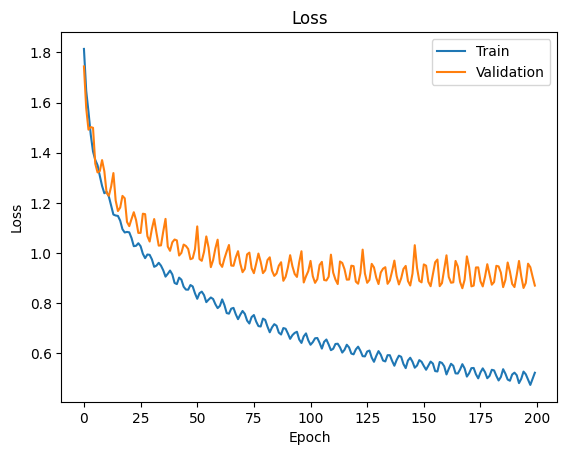

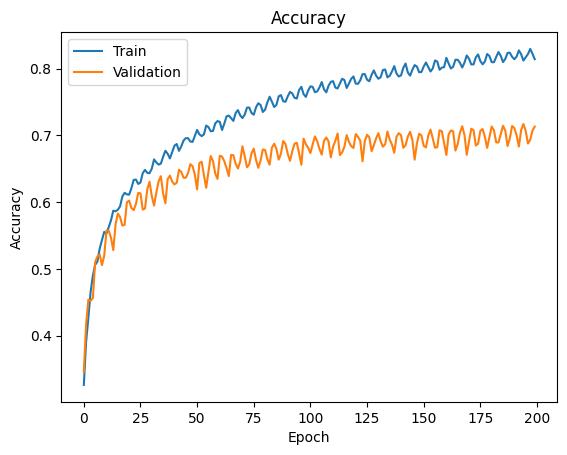

In [39]:

# Plot the training and validation loss
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [40]:
# Set the model to evaluation mode
model.eval()


# Evaluate the model on train data
train_acc = 0
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        train_acc += (output.argmax(dim=1) == labels).sum().item()
train_acc /= len(train_loader.dataset)
print(f"Train accuracy: {train_acc:.4f}")

# Evaluate the model on test data
test_acc = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        test_acc += (output.argmax(dim=1) == labels).sum().item()
test_acc /= len(test_loader.dataset)
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9120
Test accuracy: 0.7564


## (d) Experimenting by varying the number of attention heads('heads' parameter).

### (i) heads = 4 (using a constant patch_size = 4x4)

In [24]:

# Hyperparameters
image_size = 64
patch_size = 4
num_classes = 10
in_channels = 3
dim = 64  # hidden_dim
depth = 4
heads = 4
mlp_ratio = 4 # (embed dim * 4) = mlp_dim, if dim = 768, then mlp_dim = 3072
batch_size = 128
num_epochs = 200
learning_rate = 1e-3



In [25]:
# ViT architecture
# non-overlapping patches

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=in_channels, patch_size=patch_size, embed_dim=dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == W, "Input tensor must be square"
        num_patches = (H // self.patch_size) ** 2
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        return x



class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(0.1)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(0.1)

    def forward(self, x):
        B, N, E = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.head_dim ** -0.5
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = attn @ v
        x = x.transpose(1, 2).reshape(B, N, E)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio):
        super(TransformerEncoder, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        hidden_features = int(embed_dim * mlp_ratio)
        self.mlp = MLP(embed_dim, hidden_features, embed_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_size=image_size,
        in_channels=in_channels,  
        patch_size=patch_size,
        embed_dim=dim,
        depth=depth,
        num_heads=heads,
        mlp_ratio=mlp_ratio,
        num_classes=num_classes,
    ):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, embed_dim)
        num_patches = (image_size // patch_size) * (image_size // patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(0.1)

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(TransformerEncoder(embed_dim, num_heads, mlp_ratio))

        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        B, N, E = x.shape
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed[:, :N+1, :]
        x = self.pos_drop(x)


     # model does not use the CLS tokens from different layers of the model, 
    # but only from the output of the final layer for classification
        for layer in self.layers:
            x = layer(x)
    #Here, x[:, 0] selects the CLS token from the output sequence of the final transformer layer. This CLS token is then passed through a Layer Normalization (self.norm) 
    #and a linear transformation (self.fc) to get the logits for the classes.
        x = self.norm(x[:, 0])
        x = self.fc(x)
        return x
    


In [26]:
# Initialize or Define the model 

model = VisionTransformer(image_size=image_size,in_channels=in_channels,patch_size=patch_size,embed_dim=dim,depth=depth,num_heads=heads,mlp_ratio=mlp_ratio,num_classes=num_classes)



In [27]:
#Define the loss function
criterion = nn.CrossEntropyLoss()

#  Define the optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-2)

# Define the learning_rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define number of workers and GPUs
NUM_WORKERS = 8
NUM_GPUS = torch.cuda.device_count()
print(NUM_GPUS)

# CPU/GPU (device) training
model.to(device)



Using device: cuda
8


VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0): TransformerEncoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (qkv): Linear(in_features=64, out_features=192, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=64, out_features=256, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=256, out_features=64, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHead

In [29]:


# # Train the model
train_losses = []
val_losses = []
train_accs = []
val_accs = []

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss = 0
    train_acc = 0
    for images, labels in train_loader:
        # Move input tensor to GPU
        images = images.to(device)
        labels = labels.to(device)
        # Zero out gradients
        optimizer.zero_grad()
         # Forward pass
        output = model(images)
        # Calculate loss
        loss = criterion(output, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()   # GPU
        #xm.optimizer_step(optimizer)   # TPU
        
        # Update the learning rate
        scheduler.step()
        
        # Compute training statistics
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == labels).sum().item()
    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate the model on validation data
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # Move input tensor to GPU
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = nn.CrossEntropyLoss()(output, labels)
            val_loss += loss.item()
            val_acc += (output.argmax(dim=1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: train loss={train_loss:.4f}, train acc={train_acc:.4f}, val loss={val_loss:.4f}, val acc={val_acc:.4f}")
    
    # epoch time calculation
    epoch_end_time = time.time()
    epoch_training_time = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch+1} Training time: {epoch_training_time} seconds")
    print('\n')


# training time    
end_time = time.time()
training_time = end_time - start_time
print(f"Total Training time: {seconds_to_hms(training_time)}")
print('\n')    



Epoch 1: train loss=1.8480, train acc=0.3093, val loss=1.7695, val acc=0.3473
Epoch 1 Training time: 14.476391553878784 seconds


Epoch 2: train loss=1.6359, train acc=0.3948, val loss=1.5381, val acc=0.4422
Epoch 2 Training time: 14.384082794189453 seconds


Epoch 3: train loss=1.5031, train acc=0.4498, val loss=1.4120, val acc=0.4903
Epoch 3 Training time: 14.481221675872803 seconds


Epoch 4: train loss=1.3871, train acc=0.4933, val loss=1.3985, val acc=0.4922
Epoch 4 Training time: 14.492945194244385 seconds


Epoch 5: train loss=1.3003, train acc=0.5281, val loss=1.3496, val acc=0.5102
Epoch 5 Training time: 14.634396314620972 seconds


Epoch 6: train loss=1.2557, train acc=0.5451, val loss=1.2399, val acc=0.5508
Epoch 6 Training time: 14.721452713012695 seconds


Epoch 7: train loss=1.2389, train acc=0.5546, val loss=1.1908, val acc=0.5699
Epoch 7 Training time: 15.30234432220459 seconds


Epoch 8: train loss=1.1852, train acc=0.5748, val loss=1.2273, val acc=0.5574
Epoch 8 Train

Epoch 64: train loss=0.6308, train acc=0.7746, val loss=0.8646, val acc=0.6996
Epoch 64 Training time: 13.776917457580566 seconds


Epoch 65: train loss=0.6221, train acc=0.7797, val loss=0.8500, val acc=0.7046
Epoch 65 Training time: 13.72868800163269 seconds


Epoch 66: train loss=0.6460, train acc=0.7717, val loss=0.7769, val acc=0.7330
Epoch 66 Training time: 13.78353238105774 seconds


Epoch 67: train loss=0.6592, train acc=0.7652, val loss=0.7706, val acc=0.7347
Epoch 67 Training time: 13.745771408081055 seconds


Epoch 68: train loss=0.6238, train acc=0.7777, val loss=0.8367, val acc=0.7110
Epoch 68 Training time: 13.716015815734863 seconds


Epoch 69: train loss=0.6068, train acc=0.7834, val loss=0.8888, val acc=0.6935
Epoch 69 Training time: 13.661300897598267 seconds


Epoch 70: train loss=0.6192, train acc=0.7781, val loss=0.7902, val acc=0.7327
Epoch 70 Training time: 13.809268474578857 seconds


Epoch 71: train loss=0.6402, train acc=0.7716, val loss=0.7591, val acc=0.7418

Epoch 126: train loss=0.5008, train acc=0.8209, val loss=0.7048, val acc=0.7651
Epoch 126 Training time: 13.702436923980713 seconds


Epoch 127: train loss=0.4938, train acc=0.8236, val loss=0.7059, val acc=0.7605
Epoch 127 Training time: 13.662830114364624 seconds


Epoch 128: train loss=0.4673, train acc=0.8317, val loss=0.8081, val acc=0.7347
Epoch 128 Training time: 13.724431276321411 seconds


Epoch 129: train loss=0.4592, train acc=0.8365, val loss=0.7681, val acc=0.7369
Epoch 129 Training time: 13.753046751022339 seconds


Epoch 130: train loss=0.4819, train acc=0.8270, val loss=0.7215, val acc=0.7582
Epoch 130 Training time: 13.875855207443237 seconds


Epoch 131: train loss=0.4950, train acc=0.8242, val loss=0.6890, val acc=0.7744
Epoch 131 Training time: 13.715874433517456 seconds


Epoch 132: train loss=0.4870, train acc=0.8262, val loss=0.7303, val acc=0.7564
Epoch 132 Training time: 13.642557621002197 seconds


Epoch 133: train loss=0.4594, train acc=0.8372, val loss=0.808

Epoch 188: train loss=0.3785, train acc=0.8651, val loss=0.7795, val acc=0.7462
Epoch 188 Training time: 13.830727577209473 seconds


Epoch 189: train loss=0.3645, train acc=0.8687, val loss=0.7629, val acc=0.7544
Epoch 189 Training time: 13.696272611618042 seconds


Epoch 190: train loss=0.3986, train acc=0.8554, val loss=0.6938, val acc=0.7768
Epoch 190 Training time: 13.684792280197144 seconds


Epoch 191: train loss=0.4065, train acc=0.8535, val loss=0.6806, val acc=0.7808
Epoch 191 Training time: 13.735784530639648 seconds


Epoch 192: train loss=0.3914, train acc=0.8610, val loss=0.7219, val acc=0.7661
Epoch 192 Training time: 13.740959405899048 seconds


Epoch 193: train loss=0.3696, train acc=0.8686, val loss=0.7799, val acc=0.7482
Epoch 193 Training time: 13.695833444595337 seconds


Epoch 194: train loss=0.3726, train acc=0.8674, val loss=0.7407, val acc=0.7647
Epoch 194 Training time: 13.7119722366333 seconds


Epoch 195: train loss=0.4092, train acc=0.8528, val loss=0.6992,

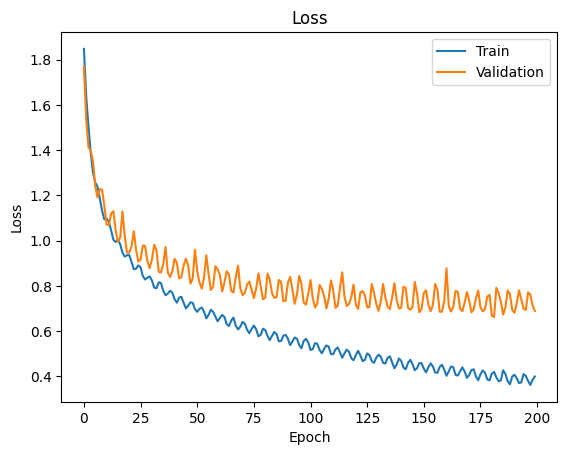

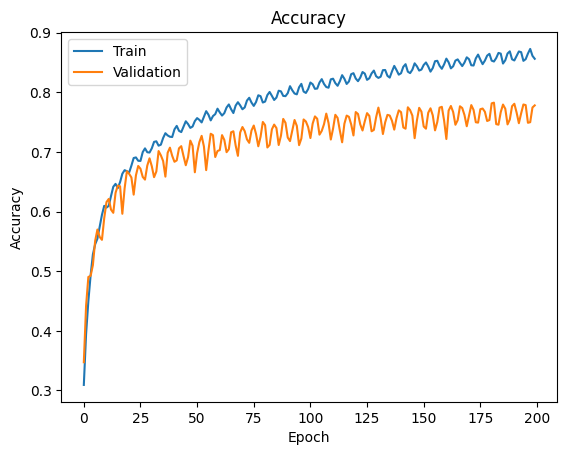

In [30]:

# Plot the training and validation loss
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [31]:
# Set the model to evaluation mode
model.eval()


# Evaluate the model on train data
train_acc = 0
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        train_acc += (output.argmax(dim=1) == labels).sum().item()
train_acc /= len(train_loader.dataset)
print(f"Train accuracy: {train_acc:.4f}")

# Evaluate the model on test data
test_acc = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        test_acc += (output.argmax(dim=1) == labels).sum().item()
test_acc /= len(test_loader.dataset)
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9251
Test accuracy: 0.8020


### (ii) heads = 16 (using a constant patch_size = 4x4)

In [32]:

# Hyperparameters
image_size = 64
patch_size = 4
num_classes = 10
in_channels = 3
dim = 64  # hidden_dim
depth = 4
heads = 16
mlp_ratio = 4 # (embed dim * 4) = mlp_dim, if dim = 768, then mlp_dim = 3072
batch_size = 128
num_epochs = 200
learning_rate = 1e-3



In [33]:
# Initialize or Define the model 

model = VisionTransformer(image_size=image_size,in_channels=in_channels,patch_size=patch_size,embed_dim=dim,depth=depth,num_heads=heads,mlp_ratio=mlp_ratio,num_classes=num_classes)


In [34]:
#Define the loss function
criterion = nn.CrossEntropyLoss()

#  Define the optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-2)

# Define the learning_rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define number of workers and GPUs
NUM_WORKERS = 8
NUM_GPUS = torch.cuda.device_count()
print(NUM_GPUS)

# CPU/GPU (device) training
model.to(device)




Using device: cuda
8


VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0): TransformerEncoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (qkv): Linear(in_features=64, out_features=192, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=64, out_features=256, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=256, out_features=64, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHead

In [36]:


# # Train the model
train_losses = []
val_losses = []
train_accs = []
val_accs = []

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss = 0
    train_acc = 0
    for images, labels in train_loader:
        # Move input tensor to GPU
        images = images.to(device)
        labels = labels.to(device)
        # Zero out gradients
        optimizer.zero_grad()
         # Forward pass
        output = model(images)
        # Calculate loss
        loss = criterion(output, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()   # GPU
        #xm.optimizer_step(optimizer)   # TPU
        
        # Update the learning rate
        scheduler.step()
        
        # Compute training statistics
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == labels).sum().item()
    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate the model on validation data
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # Move input tensor to GPU
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = nn.CrossEntropyLoss()(output, labels)
            val_loss += loss.item()
            val_acc += (output.argmax(dim=1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: train loss={train_loss:.4f}, train acc={train_acc:.4f}, val loss={val_loss:.4f}, val acc={val_acc:.4f}")
    
    # epoch time calculation
    epoch_end_time = time.time()
    epoch_training_time = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch+1} Training time: {epoch_training_time} seconds")
    print('\n')


# training time    
end_time = time.time()
training_time = end_time - start_time
print(f"Total Training time: {seconds_to_hms(training_time)}")
print('\n')    



Epoch 1: train loss=1.8545, train acc=0.3032, val loss=1.7893, val acc=0.3375
Epoch 1 Training time: 32.63675785064697 seconds


Epoch 2: train loss=1.6099, train acc=0.4055, val loss=1.5057, val acc=0.4501
Epoch 2 Training time: 32.734110593795776 seconds


Epoch 3: train loss=1.4786, train acc=0.4603, val loss=1.3869, val acc=0.4958
Epoch 3 Training time: 32.65811324119568 seconds


Epoch 4: train loss=1.3658, train acc=0.5049, val loss=1.3871, val acc=0.4997
Epoch 4 Training time: 32.777868032455444 seconds


Epoch 5: train loss=1.2714, train acc=0.5363, val loss=1.3399, val acc=0.5150
Epoch 5 Training time: 32.80032229423523 seconds


Epoch 6: train loss=1.2311, train acc=0.5576, val loss=1.2067, val acc=0.5662
Epoch 6 Training time: 32.73150157928467 seconds


Epoch 7: train loss=1.2000, train acc=0.5708, val loss=1.1564, val acc=0.5817
Epoch 7 Training time: 32.63194489479065 seconds


Epoch 8: train loss=1.1598, train acc=0.5852, val loss=1.1985, val acc=0.5751
Epoch 8 Training 

Epoch 64: train loss=0.5842, train acc=0.7933, val loss=0.8735, val acc=0.7039
Epoch 64 Training time: 32.71769833564758 seconds


Epoch 65: train loss=0.5811, train acc=0.7935, val loss=0.8670, val acc=0.7069
Epoch 65 Training time: 32.75043964385986 seconds


Epoch 66: train loss=0.6029, train acc=0.7833, val loss=0.7722, val acc=0.7361
Epoch 66 Training time: 32.7003276348114 seconds


Epoch 67: train loss=0.6026, train acc=0.7864, val loss=0.7665, val acc=0.7386
Epoch 67 Training time: 32.74916625022888 seconds


Epoch 68: train loss=0.5863, train acc=0.7918, val loss=0.8477, val acc=0.7114
Epoch 68 Training time: 32.69058537483215 seconds


Epoch 69: train loss=0.5512, train acc=0.8054, val loss=0.8297, val acc=0.7140
Epoch 69 Training time: 32.64038014411926 seconds


Epoch 70: train loss=0.5701, train acc=0.7987, val loss=0.8016, val acc=0.7288
Epoch 70 Training time: 32.731932401657104 seconds


Epoch 71: train loss=0.5923, train acc=0.7885, val loss=0.7606, val acc=0.7393
Epoc

Epoch 127: train loss=0.4358, train acc=0.8450, val loss=0.7508, val acc=0.7527
Epoch 127 Training time: 32.67705512046814 seconds


Epoch 128: train loss=0.4027, train acc=0.8569, val loss=0.7960, val acc=0.7374
Epoch 128 Training time: 32.62095856666565 seconds


Epoch 129: train loss=0.3861, train acc=0.8610, val loss=0.8420, val acc=0.7373
Epoch 129 Training time: 32.736603021621704 seconds


Epoch 130: train loss=0.4056, train acc=0.8541, val loss=0.7931, val acc=0.7474
Epoch 130 Training time: 32.66428303718567 seconds


Epoch 131: train loss=0.4302, train acc=0.8463, val loss=0.7317, val acc=0.7624
Epoch 131 Training time: 32.67885231971741 seconds


Epoch 132: train loss=0.4122, train acc=0.8514, val loss=0.7719, val acc=0.7575
Epoch 132 Training time: 32.70868754386902 seconds


Epoch 133: train loss=0.3829, train acc=0.8617, val loss=0.7929, val acc=0.7381
Epoch 133 Training time: 32.72131633758545 seconds


Epoch 134: train loss=0.3833, train acc=0.8638, val loss=0.7771, val

Epoch 189: train loss=0.2930, train acc=0.8967, val loss=0.8419, val acc=0.7508
Epoch 189 Training time: 32.72006845474243 seconds


Epoch 190: train loss=0.3325, train acc=0.8814, val loss=0.7588, val acc=0.7666
Epoch 190 Training time: 32.64092826843262 seconds


Epoch 191: train loss=0.3366, train acc=0.8789, val loss=0.7365, val acc=0.7735
Epoch 191 Training time: 32.65794229507446 seconds


Epoch 192: train loss=0.3221, train acc=0.8849, val loss=0.7837, val acc=0.7586
Epoch 192 Training time: 32.70436882972717 seconds


Epoch 193: train loss=0.2969, train acc=0.8932, val loss=0.8440, val acc=0.7428
Epoch 193 Training time: 32.65117073059082 seconds


Epoch 194: train loss=0.3014, train acc=0.8922, val loss=0.8054, val acc=0.7590
Epoch 194 Training time: 32.711201906204224 seconds


Epoch 195: train loss=0.3312, train acc=0.8820, val loss=0.7482, val acc=0.7672
Epoch 195 Training time: 32.82147145271301 seconds


Epoch 196: train loss=0.3258, train acc=0.8859, val loss=0.7368, val

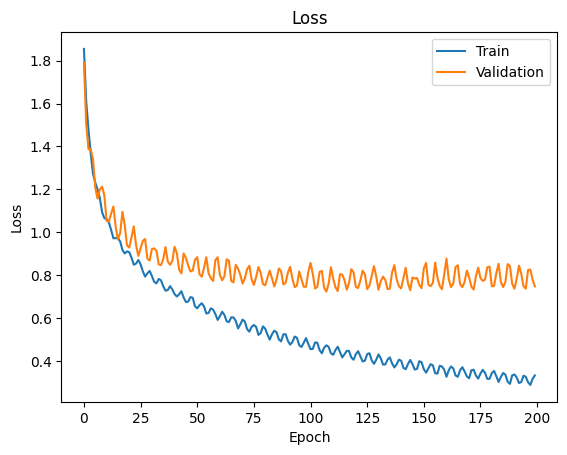

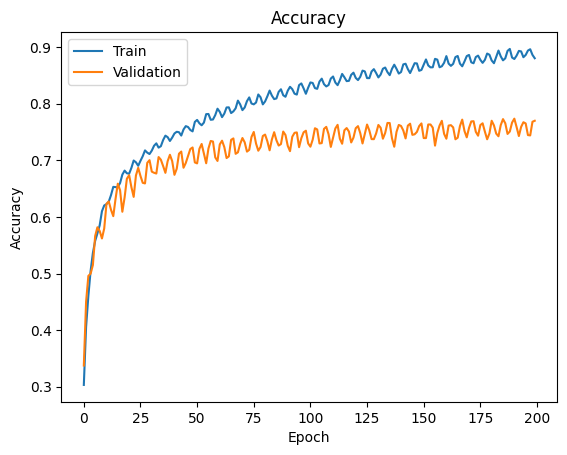

In [37]:

# Plot the training and validation loss
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [38]:
# Set the model to evaluation mode
model.eval()


# Evaluate the model on train data
train_acc = 0
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        train_acc += (output.argmax(dim=1) == labels).sum().item()
train_acc /= len(train_loader.dataset)
print(f"Train accuracy: {train_acc:.4f}")

# Evaluate the model on test data
test_acc = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        test_acc += (output.argmax(dim=1) == labels).sum().item()
test_acc /= len(test_loader.dataset)
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9506
Test accuracy: 0.7876


## (e) Performing classification by using the CLS token from different layers of the model.

### 1) With non-overlapping patches

In [39]:

# Hyperparameters
image_size = 64
patch_size = 4
num_classes = 10
in_channels = 3
dim = 64  # hidden_dim
depth = 4
heads = 8
mlp_ratio = 4 # (embed dim * 4) = mlp_dim, if dim = 768, then mlp_dim = 3072
batch_size = 128
num_epochs = 200
learning_rate = 1e-3



In [40]:
# ViT architecture
# using CLS tokens from different layers for classification
# non-overlapping

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=in_channels, patch_size=patch_size, embed_dim=dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == W, "Input tensor must be square"
        num_patches = (H // self.patch_size) ** 2
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        return x



class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(0.1)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(0.1)

    def forward(self, x):
        B, N, E = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.head_dim ** -0.5
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = attn @ v
        x = x.transpose(1, 2).reshape(B, N, E)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio):
        super(TransformerEncoder, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        hidden_features = int(embed_dim * mlp_ratio)
        self.mlp = MLP(embed_dim, hidden_features, embed_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_size=image_size,
        in_channels=in_channels,  
        patch_size=patch_size,
        embed_dim=dim,
        depth=depth,
        num_heads=heads,
        mlp_ratio=mlp_ratio,
        num_classes=num_classes,
    ):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, embed_dim)
        num_patches = (image_size // patch_size) * (image_size // patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(0.1)

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(TransformerEncoder(embed_dim, num_heads, mlp_ratio))

        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        B, N, E = x.shape
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed[:, :N+1, :]
        x = self.pos_drop(x)

        cls_tokens = []
        for layer in self.layers:
            x = layer(x)
            cls_tokens.append(x[:, 0])
    # We compute the mean along the depth dimension using cls_tokens.mean(dim=0) to get
    # the average CLS token representation. Finally, this average representation is passed through
    # Layer Normalization and the linear transformation for classification.
    
        cls_tokens = torch.stack(cls_tokens, dim=0)  # shape: (depth, B, E)
        cls_tokens_mean = cls_tokens.mean(dim=0)  # shape: (B, E)
        x = self.norm(cls_tokens_mean)
        x = self.fc(x)
        return x


In [41]:
# Initialize or Define the model 

model = VisionTransformer(image_size=image_size,in_channels=in_channels,patch_size=patch_size,embed_dim=dim,depth=depth,num_heads=heads,mlp_ratio=mlp_ratio,num_classes=num_classes)


In [42]:
#Define the loss function
criterion = nn.CrossEntropyLoss()

#  Define the optimizer 
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.05)   # for L2 regularization


# Define the learning_rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define number of workers and GPUs
NUM_WORKERS = 8
NUM_GPUS = torch.cuda.device_count()
print(NUM_GPUS)

# CPU/GPU (device) training
model.to(device)




Using device: cuda
8


VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_drop): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0): TransformerEncoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (qkv): Linear(in_features=64, out_features=192, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=64, out_features=256, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=256, out_features=64, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoder(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHead

In [44]:


# # Train the model
train_losses = []
val_losses = []
train_accs = []
val_accs = []

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss = 0
    train_acc = 0
    for images, labels in train_loader:
        # Move input tensor to GPU
        images = images.to(device)
        labels = labels.to(device)
        # Zero out gradients
        optimizer.zero_grad()
         # Forward pass
        output = model(images)
        # Calculate loss
        loss = criterion(output, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()   # GPU
        #xm.optimizer_step(optimizer)   # TPU
        
        # Update the learning rate
        scheduler.step()
        
        # Compute training statistics
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == labels).sum().item()
    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate the model on validation data
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # Move input tensor to GPU
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = nn.CrossEntropyLoss()(output, labels)
            val_loss += loss.item()
            val_acc += (output.argmax(dim=1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: train loss={train_loss:.4f}, train acc={train_acc:.4f}, val loss={val_loss:.4f}, val acc={val_acc:.4f}")
    
    # epoch time calculation
    epoch_end_time = time.time()
    epoch_training_time = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch+1} Training time: {epoch_training_time} seconds")
    print('\n')


# training time    
end_time = time.time()
training_time = end_time - start_time
print(f"Total Training time: {seconds_to_hms(training_time)}")
print('\n')    



Epoch 1: train loss=1.8404, train acc=0.3147, val loss=1.7616, val acc=0.3493
Epoch 1 Training time: 19.9764506816864 seconds


Epoch 2: train loss=1.6216, train acc=0.3989, val loss=1.5119, val acc=0.4464
Epoch 2 Training time: 19.948688507080078 seconds


Epoch 3: train loss=1.4966, train acc=0.4512, val loss=1.4162, val acc=0.4847
Epoch 3 Training time: 19.90516209602356 seconds


Epoch 4: train loss=1.3794, train acc=0.4996, val loss=1.3839, val acc=0.4974
Epoch 4 Training time: 19.944427728652954 seconds


Epoch 5: train loss=1.2779, train acc=0.5378, val loss=1.3245, val acc=0.5204
Epoch 5 Training time: 19.97371506690979 seconds


Epoch 6: train loss=1.2360, train acc=0.5554, val loss=1.2113, val acc=0.5690
Epoch 6 Training time: 19.966134309768677 seconds


Epoch 7: train loss=1.2043, train acc=0.5659, val loss=1.1587, val acc=0.5827
Epoch 7 Training time: 19.883986234664917 seconds


Epoch 8: train loss=1.1594, train acc=0.5802, val loss=1.1676, val acc=0.5845
Epoch 8 Training

Epoch 64: train loss=0.5935, train acc=0.7894, val loss=0.8708, val acc=0.6991
Epoch 64 Training time: 19.922762393951416 seconds


Epoch 65: train loss=0.5913, train acc=0.7889, val loss=0.8708, val acc=0.6977
Epoch 65 Training time: 19.972234964370728 seconds


Epoch 66: train loss=0.6175, train acc=0.7785, val loss=0.7540, val acc=0.7414
Epoch 66 Training time: 19.946058988571167 seconds


Epoch 67: train loss=0.6188, train acc=0.7801, val loss=0.7473, val acc=0.7430
Epoch 67 Training time: 19.987924337387085 seconds


Epoch 68: train loss=0.5937, train acc=0.7891, val loss=0.8225, val acc=0.7191
Epoch 68 Training time: 19.986373901367188 seconds


Epoch 69: train loss=0.5731, train acc=0.7956, val loss=0.8439, val acc=0.7070
Epoch 69 Training time: 19.950956344604492 seconds


Epoch 70: train loss=0.5863, train acc=0.7906, val loss=0.7927, val acc=0.7293
Epoch 70 Training time: 19.901437997817993 seconds


Epoch 71: train loss=0.6069, train acc=0.7834, val loss=0.7519, val acc=0.74

Epoch 126: train loss=0.4552, train acc=0.8369, val loss=0.7104, val acc=0.7710
Epoch 126 Training time: 19.852550506591797 seconds


Epoch 127: train loss=0.4569, train acc=0.8365, val loss=0.6984, val acc=0.7687
Epoch 127 Training time: 20.057878732681274 seconds


Epoch 128: train loss=0.4274, train acc=0.8475, val loss=0.7708, val acc=0.7532
Epoch 128 Training time: 20.013593912124634 seconds


Epoch 129: train loss=0.4139, train acc=0.8528, val loss=0.7922, val acc=0.7415
Epoch 129 Training time: 19.96882963180542 seconds


Epoch 130: train loss=0.4362, train acc=0.8443, val loss=0.7143, val acc=0.7710
Epoch 130 Training time: 19.987998247146606 seconds


Epoch 131: train loss=0.4501, train acc=0.8394, val loss=0.7075, val acc=0.7758
Epoch 131 Training time: 20.055665969848633 seconds


Epoch 132: train loss=0.4424, train acc=0.8420, val loss=0.7275, val acc=0.7584
Epoch 132 Training time: 20.049021244049072 seconds


Epoch 133: train loss=0.4074, train acc=0.8557, val loss=0.8130

Epoch 188: train loss=0.3422, train acc=0.8785, val loss=0.7735, val acc=0.7505
Epoch 188 Training time: 19.82795786857605 seconds


Epoch 189: train loss=0.3284, train acc=0.8812, val loss=0.7770, val acc=0.7524
Epoch 189 Training time: 20.056442260742188 seconds


Epoch 190: train loss=0.3601, train acc=0.8722, val loss=0.7111, val acc=0.7735
Epoch 190 Training time: 19.900781869888306 seconds


Epoch 191: train loss=0.3724, train acc=0.8666, val loss=0.6985, val acc=0.7808
Epoch 191 Training time: 19.99613046646118 seconds


Epoch 192: train loss=0.3543, train acc=0.8745, val loss=0.7705, val acc=0.7599
Epoch 192 Training time: 19.949016571044922 seconds


Epoch 193: train loss=0.3276, train acc=0.8839, val loss=0.7991, val acc=0.7467
Epoch 193 Training time: 19.901201486587524 seconds


Epoch 194: train loss=0.3302, train acc=0.8837, val loss=0.7655, val acc=0.7633
Epoch 194 Training time: 20.127523183822632 seconds


Epoch 195: train loss=0.3687, train acc=0.8690, val loss=0.6954,

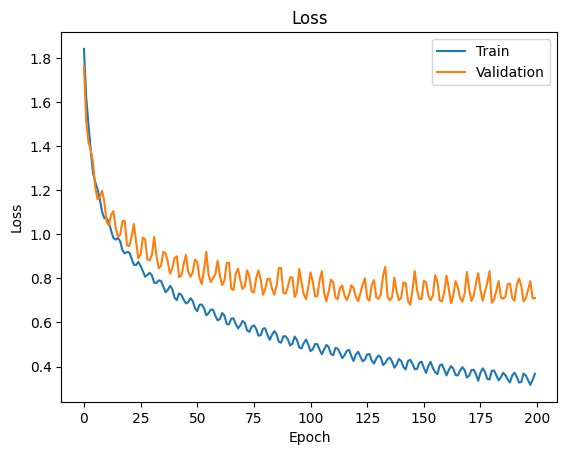

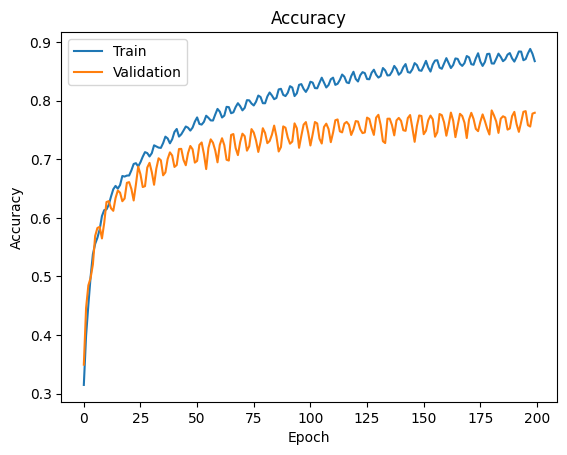

In [45]:

# Plot the training and validation loss
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [47]:
# Set the model to evaluation mode
model.eval()


# Evaluate the model on train data
train_acc = 0
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        train_acc += (output.argmax(dim=1) == labels).sum().item()
train_acc /= len(train_loader.dataset)
print(f"Train accuracy: {train_acc:.4f}")

# Evaluate the model on test data
test_acc = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        test_acc += (output.argmax(dim=1) == labels).sum().item()
test_acc /= len(test_loader.dataset)
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9383
Test accuracy: 0.7992


### 2) With overlappping patches

In [37]:

# Hyperparameters
image_size = 64
patch_size = 4
num_classes = 10
in_channels = 3
dim = 64  # hidden_dim
depth = 4
heads = 8
mlp_ratio = 4 # (embed dim * 4) = mlp_dim, if dim = 768, then mlp_dim = 3072
batch_size = 128
num_epochs = 200
learning_rate = 1e-3



In [38]:
# ViT
# using CLS tokens from different layers for classification
#  overlapping patches


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=in_channels, patch_size=patch_size, embed_dim=dim, stride=None):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.stride = stride if stride is not None else patch_size // 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=self.stride)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == W, "Input tensor must be square"
        num_patches = (((H - self.patch_size) // self.stride + 1) * ((W - self.patch_size) // self.stride + 1))
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        return x, num_patches

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(0.1)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(0.1)

    def forward(self, x):
        B, N, E = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.head_dim ** -0.5
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = attn @ v
        x = x.transpose(1, 2).reshape(B, N, E)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio):
        super(TransformerEncoder, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        hidden_features = int(embed_dim * mlp_ratio)
        self.mlp = MLP(embed_dim, hidden_features, embed_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


    
class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_size=image_size,
        in_channels=in_channels,
        patch_size=patch_size,
        embed_dim=dim,
        depth=depth,
        num_heads=heads,
        mlp_ratio=mlp_ratio,
        num_classes=num_classes,
    ):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, embed_dim)
        self.image_size = image_size
        self.patch_size = patch_size
        self.stride = self.patch_embed.stride
        self.num_patches = (((image_size - self.patch_size) // self.stride + 1) * ((image_size - self.patch_size) // self.stride + 1))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(0.1)

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(TransformerEncoder(embed_dim, num_heads, mlp_ratio))

        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x, _ = self.patch_embed(x)
        B, N, E = x.shape
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed[:, :N+1, :]
        x = self.pos_drop(x)

        cls_tokens = []
        for layer in self.layers:
            x = layer(x)
            cls_tokens.append(x[:, 0])

        cls_tokens = torch.stack(cls_tokens, dim=0)  # shape: (depth, B, E)
        cls_tokens_mean = cls_tokens.mean(dim=0)  # shape: (B, E)
        x = self.norm(cls_tokens_mean)
        x = self.fc(x)
        return x



In [39]:
# Initialize or Define the model 

model = VisionTransformer(image_size=image_size,in_channels=in_channels,patch_size=patch_size,embed_dim=dim,depth=depth,num_heads=heads,mlp_ratio=mlp_ratio,num_classes=num_classes)


In [40]:
#Define the loss function
criterion = nn.CrossEntropyLoss()

#  Define the optimizer 
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.05)   # for L2 regularization


# Define the learning_rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Define number of workers and GPUs
NUM_WORKERS = 4
NUM_GPUS = torch.cuda.device_count()
print(NUM_GPUS)

# CPU/GPU (device) training
model.to(device)

# Partition the model across GPUs using DataParallel
if NUM_GPUS > 1:
    model = DataParallel(model)

# Wrap the model with DistributedDataParallel to enable distributed training
#model = DDP(model)



Using device: cuda
8


In [42]:


# # Train the model
train_losses = []
val_losses = []
train_accs = []
val_accs = []

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss = 0
    train_acc = 0
    for images, labels in train_loader:
        # Move input tensor to GPU
        images = images.to(device)
        labels = labels.to(device)
        # Zero out gradients
        optimizer.zero_grad()
         # Forward pass
        output = model(images)
        # Calculate loss
        loss = criterion(output, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()   # GPU
        #xm.optimizer_step(optimizer)   # TPU
        
        # Update the learning rate
        scheduler.step()
        
        # Compute training statistics
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == labels).sum().item()
    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate the model on validation data
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # Move input tensor to GPU
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = nn.CrossEntropyLoss()(output, labels)
            val_loss += loss.item()
            val_acc += (output.argmax(dim=1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: train loss={train_loss:.4f}, train acc={train_acc:.4f}, val loss={val_loss:.4f}, val acc={val_acc:.4f}")
    
    # epoch time calculation
    epoch_end_time = time.time()
    epoch_training_time = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch+1} Training time: {epoch_training_time} seconds")
    print('\n')


# training time    
end_time = time.time()
training_time = end_time - start_time
print(f"Total Training time: {seconds_to_hms(training_time)}")
print('\n')    



Epoch 1: train loss=1.8093, train acc=0.3246, val loss=1.7417, val acc=0.3551
Epoch 1 Training time: 48.274600982666016 seconds


Epoch 2: train loss=1.5602, train acc=0.4288, val loss=1.4441, val acc=0.4773
Epoch 2 Training time: 49.90782141685486 seconds


Epoch 3: train loss=1.4161, train acc=0.4877, val loss=1.3226, val acc=0.5217
Epoch 3 Training time: 48.05527687072754 seconds


Epoch 4: train loss=1.2971, train acc=0.5302, val loss=1.2967, val acc=0.5378
Epoch 4 Training time: 47.970680236816406 seconds


Epoch 5: train loss=1.2167, train acc=0.5625, val loss=1.2603, val acc=0.5486
Epoch 5 Training time: 47.352498054504395 seconds


Epoch 6: train loss=1.1727, train acc=0.5773, val loss=1.1588, val acc=0.5816
Epoch 6 Training time: 47.77493762969971 seconds


Epoch 7: train loss=1.1397, train acc=0.5904, val loss=1.0766, val acc=0.6173
Epoch 7 Training time: 48.303547382354736 seconds


Epoch 8: train loss=1.0959, train acc=0.6056, val loss=1.0904, val acc=0.6144
Epoch 8 Trainin

Epoch 64: train loss=0.5469, train acc=0.8050, val loss=0.8215, val acc=0.7198
Epoch 64 Training time: 47.631810426712036 seconds


Epoch 65: train loss=0.5423, train acc=0.8076, val loss=0.7640, val acc=0.7392
Epoch 65 Training time: 46.80226492881775 seconds


Epoch 66: train loss=0.5677, train acc=0.7964, val loss=0.7190, val acc=0.7555
Epoch 66 Training time: 46.239227294921875 seconds


Epoch 67: train loss=0.5687, train acc=0.7982, val loss=0.7140, val acc=0.7610
Epoch 67 Training time: 47.52084016799927 seconds


Epoch 68: train loss=0.5470, train acc=0.8050, val loss=0.7724, val acc=0.7333
Epoch 68 Training time: 47.628472089767456 seconds


Epoch 69: train loss=0.5176, train acc=0.8181, val loss=0.8346, val acc=0.7153
Epoch 69 Training time: 46.959065198898315 seconds


Epoch 70: train loss=0.5380, train acc=0.8092, val loss=0.7404, val acc=0.7493
Epoch 70 Training time: 47.25417876243591 seconds


Epoch 71: train loss=0.5610, train acc=0.8022, val loss=0.7085, val acc=0.7611


Epoch 127: train loss=0.4127, train acc=0.8528, val loss=0.7041, val acc=0.7723
Epoch 127 Training time: 45.584511041641235 seconds


Epoch 128: train loss=0.3891, train acc=0.8612, val loss=0.7853, val acc=0.7430
Epoch 128 Training time: 45.41758608818054 seconds


Epoch 129: train loss=0.3729, train acc=0.8658, val loss=0.7862, val acc=0.7421
Epoch 129 Training time: 45.317950963974 seconds


Epoch 130: train loss=0.3916, train acc=0.8586, val loss=0.7171, val acc=0.7701
Epoch 130 Training time: 45.06999182701111 seconds


Epoch 131: train loss=0.4147, train acc=0.8509, val loss=0.6861, val acc=0.7803
Epoch 131 Training time: 45.461766719818115 seconds


Epoch 132: train loss=0.3952, train acc=0.8607, val loss=0.6878, val acc=0.7739
Epoch 132 Training time: 45.26598381996155 seconds


Epoch 133: train loss=0.3729, train acc=0.8665, val loss=0.7532, val acc=0.7550
Epoch 133 Training time: 45.40528130531311 seconds


Epoch 134: train loss=0.3663, train acc=0.8694, val loss=0.7461, val 

Epoch 189: train loss=0.2871, train acc=0.8973, val loss=0.7720, val acc=0.7667
Epoch 189 Training time: 45.40854859352112 seconds


Epoch 190: train loss=0.3100, train acc=0.8898, val loss=0.7207, val acc=0.7797
Epoch 190 Training time: 45.27711033821106 seconds


Epoch 191: train loss=0.3320, train acc=0.8799, val loss=0.6840, val acc=0.7880
Epoch 191 Training time: 45.56755352020264 seconds


Epoch 192: train loss=0.3233, train acc=0.8851, val loss=0.7549, val acc=0.7678
Epoch 192 Training time: 45.330758810043335 seconds


Epoch 193: train loss=0.2862, train acc=0.8983, val loss=0.7837, val acc=0.7574
Epoch 193 Training time: 45.36820411682129 seconds


Epoch 194: train loss=0.3029, train acc=0.8927, val loss=0.7569, val acc=0.7668
Epoch 194 Training time: 45.44969320297241 seconds


Epoch 195: train loss=0.3327, train acc=0.8809, val loss=0.7172, val acc=0.7802
Epoch 195 Training time: 45.05812358856201 seconds


Epoch 196: train loss=0.3345, train acc=0.8796, val loss=0.7213, val

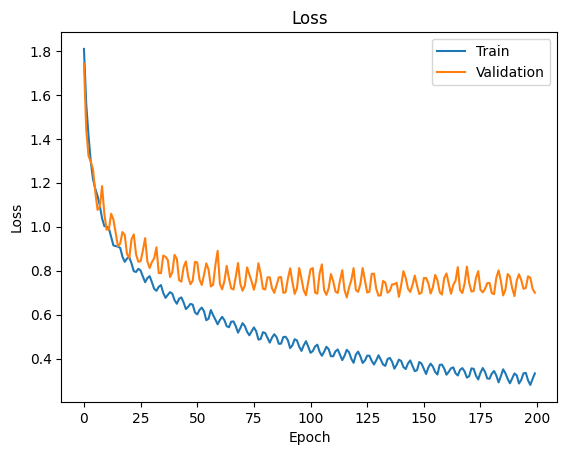

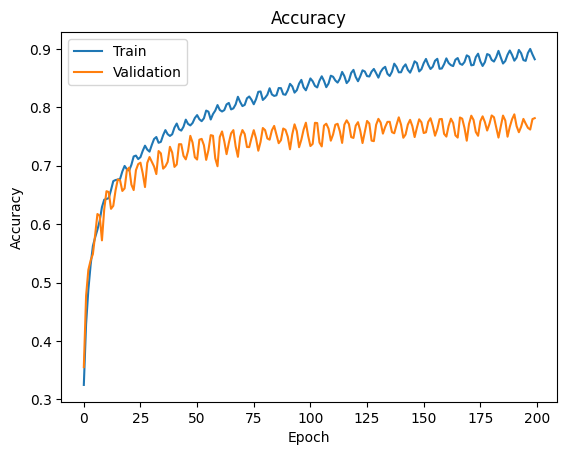

In [43]:

# Plot the training and validation loss
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [44]:
# Set the model to evaluation mode
model.eval()


# Evaluate the model on train data
train_acc = 0
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        train_acc += (output.argmax(dim=1) == labels).sum().item()
train_acc /= len(train_loader.dataset)
print(f"Train accuracy: {train_acc:.4f}")

# Evaluate the model on test data
test_acc = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        test_acc += (output.argmax(dim=1) == labels).sum().item()
test_acc /= len(test_loader.dataset)
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9496
Test accuracy: 0.8031


## Experimenting with 8 attention layers (increasing from 4 layers) and running for 400 epochs. (non-overlapping patches) 

In [51]:

# Hyperparameters
image_size = 128   # resized from 32(original cifar-10 size) to 64 for utilizing more pixels.
patch_size = 8
num_classes = 10
in_channels = 3
dim = 128  # hidden_dim
depth = 8
heads = 8
#mlp_dim = 512
mlp_ratio = 4 # (embed dim * 4) = mlp_dim, if dim = 768, then mlp_dim = 3072
#dropout = 0.1
batch_size = 128
num_epochs = 400
learning_rate = 1e-3



In [52]:
# ViT architecture
# non-overlapping patches

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=in_channels, patch_size=patch_size, embed_dim=dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == W, "Input tensor must be square"
        num_patches = (H // self.patch_size) ** 2
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        return x



class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(0.1)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(0.1)

    def forward(self, x):
        B, N, E = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.head_dim ** -0.5
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = attn @ v
        x = x.transpose(1, 2).reshape(B, N, E)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio):
        super(TransformerEncoder, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        hidden_features = int(embed_dim * mlp_ratio)
        self.mlp = MLP(embed_dim, hidden_features, embed_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(
        self,
        image_size=image_size,
        in_channels=in_channels,  
        patch_size=patch_size,
        embed_dim=dim,
        depth=depth,
        num_heads=heads,
        mlp_ratio=mlp_ratio,
        num_classes=num_classes,
    ):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, embed_dim)
        num_patches = (image_size // patch_size) * (image_size // patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(0.1)

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(TransformerEncoder(embed_dim, num_heads, mlp_ratio))

        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        B, N, E = x.shape
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed[:, :N+1, :]
        x = self.pos_drop(x)


     # model does not use the CLS tokens from different layers of the model, 
    # but only from the output of the final layer for classification
        for layer in self.layers:
            x = layer(x)
    #Here, x[:, 0] selects the CLS token from the output sequence of the final transformer layer. This CLS token is then passed through a Layer Normalization (self.norm) 
    #and a linear transformation (self.fc) to get the logits for the classes.
        x = self.norm(x[:, 0])
        x = self.fc(x)
        return x
    


In [53]:


transform_train = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


In [54]:
#Download dataset
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)



Files already downloaded and verified
Files already downloaded and verified


In [55]:

# Split the train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


In [56]:
# Initialize or Define the model 

model = VisionTransformer(image_size=image_size,in_channels=in_channels,patch_size=patch_size,embed_dim=dim,depth=depth,num_heads=heads,mlp_ratio=mlp_ratio,num_classes=num_classes)



In [57]:
#Define the loss function
criterion = nn.CrossEntropyLoss()

#  Define the optimizer 
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.5)   # for L2 regularization
 


# Define the learning_rate scheduler
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Define number of workers and GPUs
NUM_WORKERS = 4
NUM_GPUS = torch.cuda.device_count()
print(NUM_GPUS)

# CPU/GPU (device) training
model.to(device)

# Partition the model across GPUs using DataParallel
if NUM_GPUS > 1:
    model = DataParallel(model)

# Wrap the model with DistributedDataParallel to enable distributed training
#model = DDP(model)



Using device: cuda
8


In [59]:

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)




In [60]:


# # Train the model
train_losses = []
val_losses = []
train_accs = []
val_accs = []

start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    train_loss = 0
    train_acc = 0
    for images, labels in train_loader:
        # Move input tensor to GPU
        images = images.to(device)
        labels = labels.to(device)
        # Zero out gradients
        optimizer.zero_grad()
         # Forward pass
        output = model(images)
        # Calculate loss
        loss = criterion(output, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()   # GPU
        #xm.optimizer_step(optimizer)   # TPU
        
        # Update the learning rate
        scheduler.step()
        
        # Compute training statistics
        train_loss += loss.item()
        train_acc += (output.argmax(dim=1) == labels).sum().item()
    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluate the model on validation data
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # Move input tensor to GPU
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = nn.CrossEntropyLoss()(output, labels)
            val_loss += loss.item()
            val_acc += (output.argmax(dim=1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: train loss={train_loss:.4f}, train acc={train_acc:.4f}, val loss={val_loss:.4f}, val acc={val_acc:.4f}")
    
    # epoch time calculation
    epoch_end_time = time.time()
    epoch_training_time = epoch_end_time - epoch_start_time
    print(f"Epoch {epoch+1} Training time: {epoch_training_time} seconds")
    print('\n')


# training time    
end_time = time.time()
training_time = end_time - start_time
print(f"Total Training time: {seconds_to_hms(training_time)}")
print('\n')    



Epoch 1: train loss=1.8543, train acc=0.3045, val loss=1.6720, val acc=0.3779
Epoch 1 Training time: 37.24320101737976 seconds


Epoch 2: train loss=1.6330, train acc=0.3966, val loss=1.6747, val acc=0.3875
Epoch 2 Training time: 36.23152208328247 seconds


Epoch 3: train loss=1.5905, train acc=0.4153, val loss=1.5246, val acc=0.4389
Epoch 3 Training time: 35.62958240509033 seconds


Epoch 4: train loss=1.3728, train acc=0.5030, val loss=1.3520, val acc=0.5095
Epoch 4 Training time: 36.4422070980072 seconds


Epoch 5: train loss=1.3854, train acc=0.4990, val loss=1.4935, val acc=0.4511
Epoch 5 Training time: 36.38351321220398 seconds


Epoch 6: train loss=1.3381, train acc=0.5167, val loss=1.2598, val acc=0.5488
Epoch 6 Training time: 36.03457832336426 seconds


Epoch 7: train loss=1.1731, train acc=0.5811, val loss=1.2901, val acc=0.5316
Epoch 7 Training time: 37.055315256118774 seconds


Epoch 8: train loss=1.2778, train acc=0.5424, val loss=1.3491, val acc=0.5193
Epoch 8 Training ti

Epoch 64: train loss=0.8940, train acc=0.6856, val loss=1.0366, val acc=0.6376
Epoch 64 Training time: 36.07453942298889 seconds


Epoch 65: train loss=0.8652, train acc=0.6968, val loss=0.8371, val acc=0.7103
Epoch 65 Training time: 36.019670486450195 seconds


Epoch 66: train loss=0.7808, train acc=0.7279, val loss=0.9851, val acc=0.6591
Epoch 66 Training time: 36.47519493103027 seconds


Epoch 67: train loss=0.9360, train acc=0.6702, val loss=0.9479, val acc=0.6682
Epoch 67 Training time: 36.43415880203247 seconds


Epoch 68: train loss=0.7876, train acc=0.7258, val loss=0.8545, val acc=0.7068
Epoch 68 Training time: 36.27253460884094 seconds


Epoch 69: train loss=0.8664, train acc=0.6942, val loss=1.0000, val acc=0.6512
Epoch 69 Training time: 36.426058769226074 seconds


Epoch 70: train loss=0.8846, train acc=0.6902, val loss=0.8492, val acc=0.7056
Epoch 70 Training time: 36.352394104003906 seconds


Epoch 71: train loss=0.7608, train acc=0.7365, val loss=1.0162, val acc=0.6543
E

Epoch 126: train loss=0.8672, train acc=0.6963, val loss=0.8648, val acc=0.7000
Epoch 126 Training time: 36.5577495098114 seconds


Epoch 127: train loss=0.7151, train acc=0.7530, val loss=0.8229, val acc=0.7176
Epoch 127 Training time: 35.81346416473389 seconds


Epoch 128: train loss=0.8622, train acc=0.6989, val loss=0.9252, val acc=0.6757
Epoch 128 Training time: 36.06611156463623 seconds


Epoch 129: train loss=0.7935, train acc=0.7244, val loss=0.7952, val acc=0.7258
Epoch 129 Training time: 35.71715307235718 seconds


Epoch 130: train loss=0.7510, train acc=0.7409, val loss=0.9462, val acc=0.6656
Epoch 130 Training time: 35.96033334732056 seconds


Epoch 131: train loss=0.8839, train acc=0.6915, val loss=0.9212, val acc=0.6864
Epoch 131 Training time: 36.548306703567505 seconds


Epoch 132: train loss=0.7166, train acc=0.7532, val loss=0.8179, val acc=0.7125
Epoch 132 Training time: 36.85969877243042 seconds


Epoch 133: train loss=0.8419, train acc=0.7073, val loss=0.9862, val 

Epoch 188: train loss=0.7315, train acc=0.7488, val loss=0.7696, val acc=0.7389
Epoch 188 Training time: 36.11668610572815 seconds


Epoch 189: train loss=0.7676, train acc=0.7337, val loss=0.9747, val acc=0.6603
Epoch 189 Training time: 36.62114715576172 seconds


Epoch 190: train loss=0.8420, train acc=0.7049, val loss=0.8274, val acc=0.7094
Epoch 190 Training time: 35.955015659332275 seconds


Epoch 191: train loss=0.6835, train acc=0.7637, val loss=0.8671, val acc=0.6979
Epoch 191 Training time: 36.137139558792114 seconds


Epoch 192: train loss=0.8393, train acc=0.7077, val loss=0.9902, val acc=0.6638
Epoch 192 Training time: 36.157607555389404 seconds


Epoch 193: train loss=0.7572, train acc=0.7405, val loss=0.7681, val acc=0.7347
Epoch 193 Training time: 36.18728256225586 seconds


Epoch 194: train loss=0.7382, train acc=0.7445, val loss=0.9673, val acc=0.6558
Epoch 194 Training time: 36.024412870407104 seconds


Epoch 195: train loss=0.8381, train acc=0.7070, val loss=0.8181, 

Epoch 250: train loss=0.6897, train acc=0.7620, val loss=0.8611, val acc=0.7023
Epoch 250 Training time: 36.53682613372803 seconds


Epoch 251: train loss=0.8360, train acc=0.7071, val loss=0.8491, val acc=0.7041
Epoch 251 Training time: 36.24884486198425 seconds


Epoch 252: train loss=0.6947, train acc=0.7614, val loss=0.7602, val acc=0.7407
Epoch 252 Training time: 36.44614839553833 seconds


Epoch 253: train loss=0.7750, train acc=0.7326, val loss=0.9186, val acc=0.6741
Epoch 253 Training time: 37.06394100189209 seconds


Epoch 254: train loss=0.7980, train acc=0.7243, val loss=0.7885, val acc=0.7276
Epoch 254 Training time: 36.7966685295105 seconds


Epoch 255: train loss=0.6744, train acc=0.7688, val loss=0.8250, val acc=0.7183
Epoch 255 Training time: 36.21743130683899 seconds


Epoch 256: train loss=0.8459, train acc=0.7068, val loss=0.9477, val acc=0.6754
Epoch 256 Training time: 36.47363257408142 seconds


Epoch 257: train loss=0.7081, train acc=0.7559, val loss=0.7515, val a

Epoch 312: train loss=0.8053, train acc=0.7218, val loss=0.9427, val acc=0.6701
Epoch 312 Training time: 37.18075942993164 seconds


Epoch 313: train loss=0.7560, train acc=0.7383, val loss=0.7473, val acc=0.7427
Epoch 313 Training time: 35.84585404396057 seconds


Epoch 314: train loss=0.6934, train acc=0.7632, val loss=0.8948, val acc=0.6849
Epoch 314 Training time: 35.843042612075806 seconds


Epoch 315: train loss=0.8412, train acc=0.7089, val loss=0.8578, val acc=0.7025
Epoch 315 Training time: 35.76366090774536 seconds


Epoch 316: train loss=0.6731, train acc=0.7698, val loss=0.7600, val acc=0.7389
Epoch 316 Training time: 36.361072301864624 seconds


Epoch 317: train loss=0.7878, train acc=0.7289, val loss=0.9232, val acc=0.6785
Epoch 317 Training time: 36.76154637336731 seconds


Epoch 318: train loss=0.7701, train acc=0.7321, val loss=0.7506, val acc=0.7425
Epoch 318 Training time: 36.417147159576416 seconds


Epoch 319: train loss=0.6746, train acc=0.7691, val loss=0.9123, v

Epoch 374: train loss=0.8138, train acc=0.7141, val loss=0.8153, val acc=0.7177
Epoch 374 Training time: 36.239009141922 seconds


Epoch 375: train loss=0.6514, train acc=0.7768, val loss=0.8075, val acc=0.7204
Epoch 375 Training time: 36.325002670288086 seconds


Epoch 376: train loss=0.8117, train acc=0.7195, val loss=0.9024, val acc=0.6897
Epoch 376 Training time: 36.135419607162476 seconds


Epoch 377: train loss=0.7102, train acc=0.7564, val loss=0.7465, val acc=0.7439
Epoch 377 Training time: 36.25783610343933 seconds


Epoch 378: train loss=0.7093, train acc=0.7557, val loss=0.9321, val acc=0.6686
Epoch 378 Training time: 36.89222478866577 seconds


Epoch 379: train loss=0.8179, train acc=0.7179, val loss=0.8219, val acc=0.7209
Epoch 379 Training time: 36.15944957733154 seconds


Epoch 380: train loss=0.6571, train acc=0.7733, val loss=0.7860, val acc=0.7330
Epoch 380 Training time: 36.250816106796265 seconds


Epoch 381: train loss=0.7863, train acc=0.7274, val loss=0.9045, val

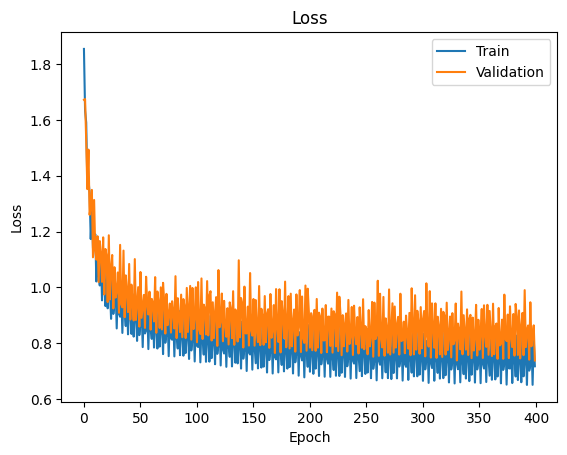

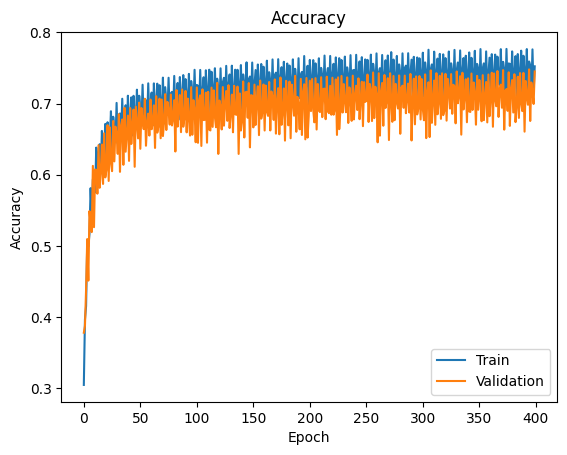

In [61]:

# Plot the training and validation loss
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [62]:
# Set the model to evaluation mode
model.eval()


# Evaluate the model on train data
train_acc = 0
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        train_acc += (output.argmax(dim=1) == labels).sum().item()
train_acc /= len(train_loader.dataset)
print(f"Train accuracy: {train_acc:.4f}")

# Evaluate the model on test data
test_acc = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device) # move images to GPU
        labels = labels.to(device)
        output = model(images)
        test_acc += (output.argmax(dim=1) == labels).sum().item()
test_acc /= len(test_loader.dataset)
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.7972
Test accuracy: 0.7579


**Here, we see that the model is not overfitting much. We need to train for more epochs to increase the test accuracy.**